In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

## Functions

### Model Training

In [40]:
def plot_graphs(history, strings, filename=None):
    """Function to plot graphs for two training history parameters (eg accuracy and loss)
    Args:
        1) history - model training history
        2) strings - an array of names of history parameters (only the data of the first two history parameters specified in this array will be taken for graphing)
        3) filename - the relative path where the file will be saved (with the file name, the file extension is not required) or just the filename
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(history.history[strings[0]], label=strings[0])
    axes[0].plot(history.history[f"val_{strings[0]}"], label=f"val_{strings[0]}")
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel(strings[0])
    axes[0].legend()
    
    axes[1].plot(history.history[strings[1]], label=strings[1])
    axes[1].plot(history.history[f"val_{strings[1]}"], label=f"val_{strings[1]}")
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel(strings[1])
    axes[1].legend()
    
    if filename:
        plt.savefig(f"{filename}.png", bbox_inches='tight')
    plt.show()

## Read data

In [94]:
df = pd.read_csv('data/final_data/balanced_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41326 entries, 0 to 41325
Columns: 112 entries, TransactionID to isFraud
dtypes: float64(105), int64(7)
memory usage: 35.3 MB


In [3]:
df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V313,V314,V315,V316,V317,V318,V319,V320,V321,isFraud
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


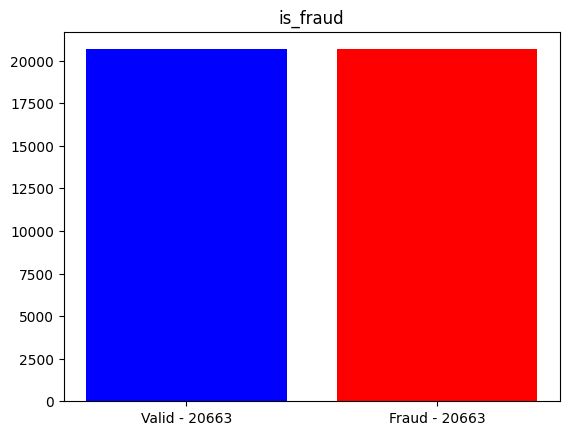

In [4]:
plt.rcdefaults()
# obtain ground truth from train column
is_fraud = df['isFraud'].values

# get counts of fruad and not fruad
__num_valid = np.sum(is_fraud == 0)
__num_fraud = is_fraud.size - __num_valid

plt.bar([0, 1], [__num_valid, __num_fraud], color=['blue', 'red'], tick_label=[f"Valid - {__num_valid}", f"Fraud - {__num_fraud}"])
plt.title('is_fraud')
plt.savefig('graphs/train_barplot.png')
plt.show()

## Divide the data into training, validation and test data and prepare for model training

### Divide data into train_df and test_df

In [25]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()


counter = 0

for label in df['isFraud'].unique():
    label_data = df[df['isFraud'] == label].copy()
    label_data.reset_index(inplace=True)
    label_data.drop('index', axis=1, inplace=True)
    
    split_index = int(0.8 * len(label_data))
    if counter != 0:
        train_df = pd.concat([train_df, label_data[:split_index]])
        test_df = pd.concat([test_df, label_data[split_index:]])
    else:
        train_df = label_data[:split_index]
        test_df = label_data[split_index:]
        
    counter += 1
    
print(f'len(train_df) = {len(train_df)}')
print(f'len(test_df) = {len(test_df)}')

len(train_df) = 33060
len(test_df) = 8266


#### View the distribution of classes in train and test data

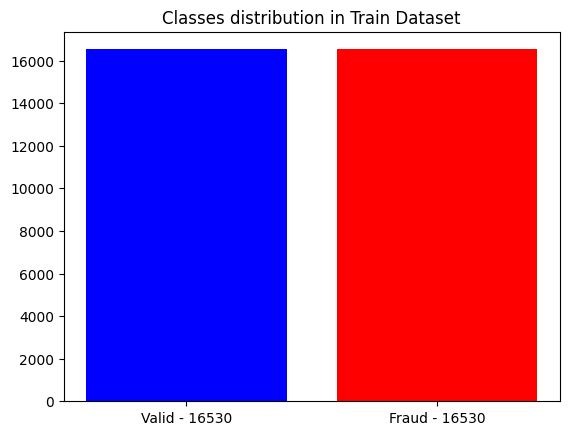

In [6]:
plt.rcdefaults()
# obtain ground truth from train column
is_fraud = train_df['isFraud'].values

# get counts of fruad and not fruad
__num_valid = np.sum(is_fraud == 0)
__num_fraud = is_fraud.size - __num_valid

plt.bar([0, 1], [__num_valid, __num_fraud], color=['blue', 'red'], tick_label=[f"Valid - {__num_valid}", f"Fraud - {__num_fraud}"])
plt.title('Classes distribution in Train Dataset')
plt.savefig('graphs/train_barplot.png')
plt.show()

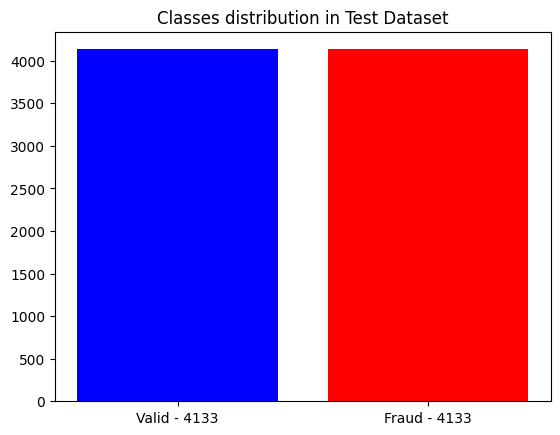

In [7]:
# obtain ground truth from train column
is_fraud = test_df['isFraud'].values

# get counts of fruad and not fruad
__num_valid = np.sum(is_fraud == 0)
__num_fraud = is_fraud.size - __num_valid

plt.bar([0, 1], [__num_valid, __num_fraud], color=['blue', 'red'], tick_label=[f"Valid - {__num_valid}", f"Fraud - {__num_fraud}"])
plt.title('Classes distribution in Test Dataset')
plt.savefig('graphs/test_barplot.png')
plt.show()

### Divide train_df into X_train, y_train, X_valid, y_valid

In [26]:
X_train = pd.DataFrame()
y_train = []

X_valid = pd.DataFrame()
y_valid = []

counter = 0

for label in train_df['isFraud'].unique():
    label_data = train_df[train_df['isFraud'] == label].copy()
    label_data.reset_index(inplace=True)
    label_data.drop('index', axis=1, inplace=True)
    split_index = int(0.8 * len(label_data))
    
    if counter != 0:
        X_train = pd.concat([X_train, label_data[label_data.columns[:-1]][:split_index]])
        X_valid = pd.concat([X_valid, label_data[label_data.columns[:-1]][split_index:]])
    else:
        X_train = label_data[label_data.columns[:-1]][:split_index]
        X_valid = label_data[label_data.columns[:-1]][split_index:]
        
    y_train.extend(list(label_data['isFraud'].values[:split_index]))
    y_valid.extend(list(label_data['isFraud'].values[split_index:]))
    counter += 1
    
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

len(X_train) = 26448
len(y_train) = 26448
len(X_valid) = 6612
len(y_valid) = 6612


### Divide test_df into X_test and y_test

In [27]:
X_test = test_df[test_df.columns[:-1]]
y_test = test_df['isFraud'].values
len(X_test)

8266

### View the distribution of classes in train, validation and test data

In [10]:
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'\nlen(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

print(f'\nlen(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_train) = 26448
len(y_train) = 26448

len(X_valid) = 6612
len(y_valid) = 6612

len(X_test) = 8266
len(y_test) = 8266


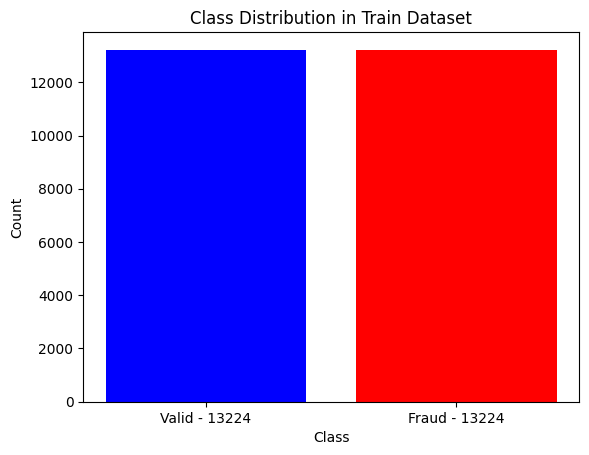

In [11]:
# Calculate counts for y_train
num_valid_train = np.sum(np.array(y_train) == 0)
num_fraud_train = len(y_train) - num_valid_train

# Create the barplot
plt.bar([0, 1], [num_valid_train, num_fraud_train], color=['blue', 'red'], tick_label=[f"Valid - {num_valid_train}", f"Fraud - {num_fraud_train}"])

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Train Dataset')
plt.savefig('graphs/train_barplot.png')
plt.show()

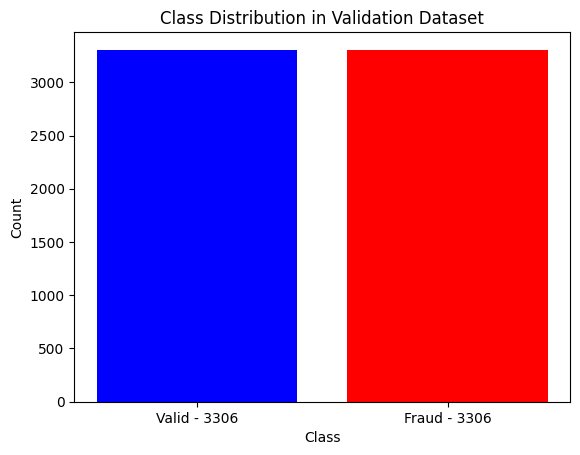

In [12]:
# Calculate counts for y_train
num_valid_train = np.sum(np.array(y_valid) == 0)
num_fraud_train = len(y_valid) - num_valid_train

# Create the barplot
plt.bar([0, 1], [num_valid_train, num_fraud_train], color=['blue', 'red'], tick_label=[f"Valid - {num_valid_train}", f"Fraud - {num_fraud_train}"])

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Validation Dataset')
plt.savefig('graphs/validation_barplot.png')
plt.show()

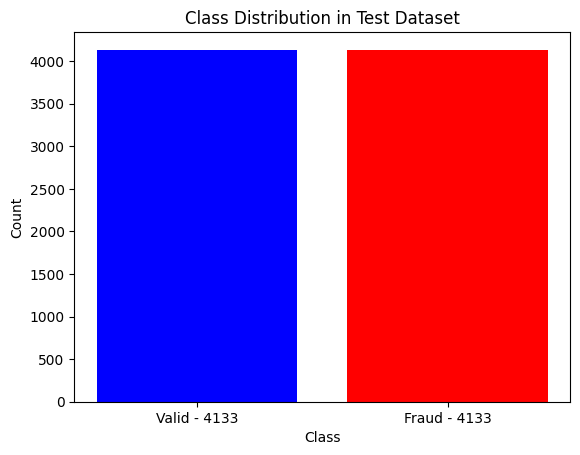

In [13]:
# Calculate counts for y_train
num_valid_train = np.sum(np.array(y_test) == 0)
num_fraud_train = len(y_test) - num_valid_train

# Create the barplot
plt.bar([0, 1], [num_valid_train, num_fraud_train], color=['blue', 'red'], tick_label=[f"Valid - {num_valid_train}", f"Fraud - {num_fraud_train}"])

# Customize the plot
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Test Dataset')
plt.savefig('graphs/test_barplot.png')
plt.show()

### Scale X_train, X_valid, X_test datasets

In [28]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

### Prepare target vectors

In [29]:
y_train = np.array(y_train)
y_valid = np.array(y_valid)
y_test = np.array(y_test)

## Test model training

In [30]:
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_valid) = {len(X_valid)}')
print(f'len(y_valid) = {len(y_valid)}')

print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_train) = 26448
len(y_train) = 26448
len(X_valid) = 6612
len(y_valid) = 6612
len(X_test) = 8266
len(y_test) = 8266


In [33]:
best_model = None
best_model_accuracy = None
best_model_history = None

experiments_number = 3

accuracy_list = []

for i in range(experiments_number):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(len(X_train.columns), )))
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(8, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

    history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=10, validation_data=(X_valid_scaled, y_valid))
          
    # evaluate the keras model
    _, accuracy = model.evaluate(X_test_scaled, y_test)
        
    accuracy_list.append(accuracy)
    print(f'Accuracy: {accuracy*100:.3f}')
    
    if best_model == None:
        best_model = model
        best_model_accuracy = accuracy
        best_model_history = history
        continue
        
    if accuracy > best_model_accuracy:
        best_model_accuracy = accuracy
        best_model = model
        best_model_history = history
        print(f'best_model_accuracy: {accuracy*100:.3f}')
        
print(f'\nAverage accuracy = {np.mean(accuracy_list)*100:.3f}')

Epoch 1/10
2645/2645 [==============================] - 4s 1ms/step - loss: 0.4730 - accuracy: 0.7771 - val_loss: 1.0216 - val_accuracy: 0.5891
Epoch 2/10
2645/2645 [==============================] - 4s 1ms/step - loss: 0.4309 - accuracy: 0.8002 - val_loss: 1.3658 - val_accuracy: 0.5632
Epoch 3/10
2645/2645 [==============================] - 4s 1ms/step - loss: 0.4226 - accuracy: 0.8072 - val_loss: 1.4234 - val_accuracy: 0.5842
Epoch 4/10
2645/2645 [==============================] - 5s 2ms/step - loss: 0.4157 - accuracy: 0.8114 - val_loss: 1.3401 - val_accuracy: 0.6165
Epoch 5/10
2645/2645 [==============================] - 4s 2ms/step - loss: 0.4090 - accuracy: 0.8125 - val_loss: 2.2043 - val_accuracy: 0.5555
Epoch 6/10
2645/2645 [==============================] - 4s 2ms/step - loss: 0.4073 - accuracy: 0.8158 - val_loss: 2.2641 - val_accuracy: 0.5697
Epoch 7/10
2645/2645 [==============================] - 4s 1ms/step - loss: 0.4068 - accuracy: 0.8174 - val_loss: 2.0855 - val_accuracy:

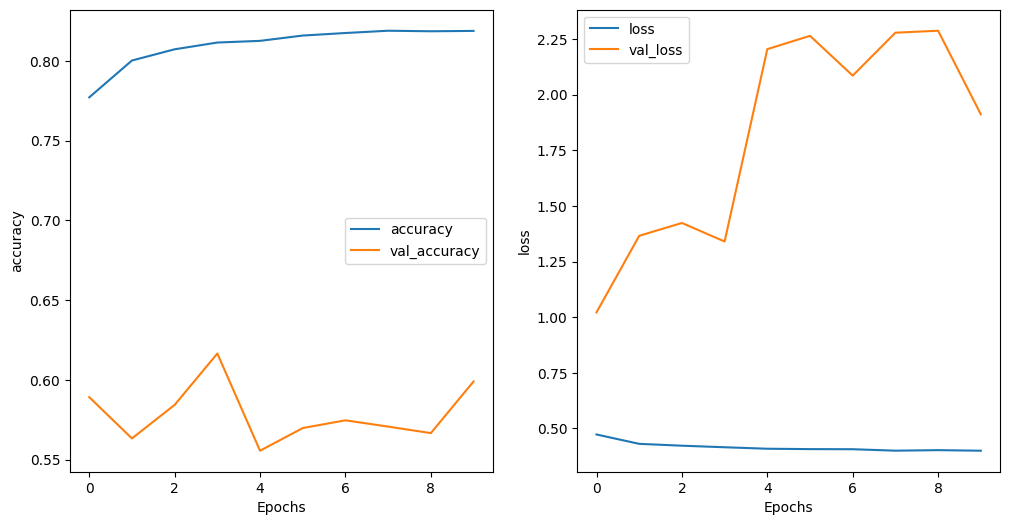

In [41]:
plot_graphs(history=best_model_history, strings=['accuracy', 'loss'], filename='graphs/accuracy_loss')

## Use RFE to assess the informativeness of inputs

In [ ]:
# Create a RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create an RFE model
rfe = RFE(estimator=rf_model, n_features_to_select=1)

# Fit RFE model on your data
rfe.fit(X_train_scaled, y_train)

# Get feature rankings from RFE
feature_rankings = rfe.ranking_

# Get feature names
feature_names = X_train.columns

# Sort features by rankings
sorted_indices = np.argsort(feature_rankings)
sorted_feature_names = feature_names[sorted_indices]

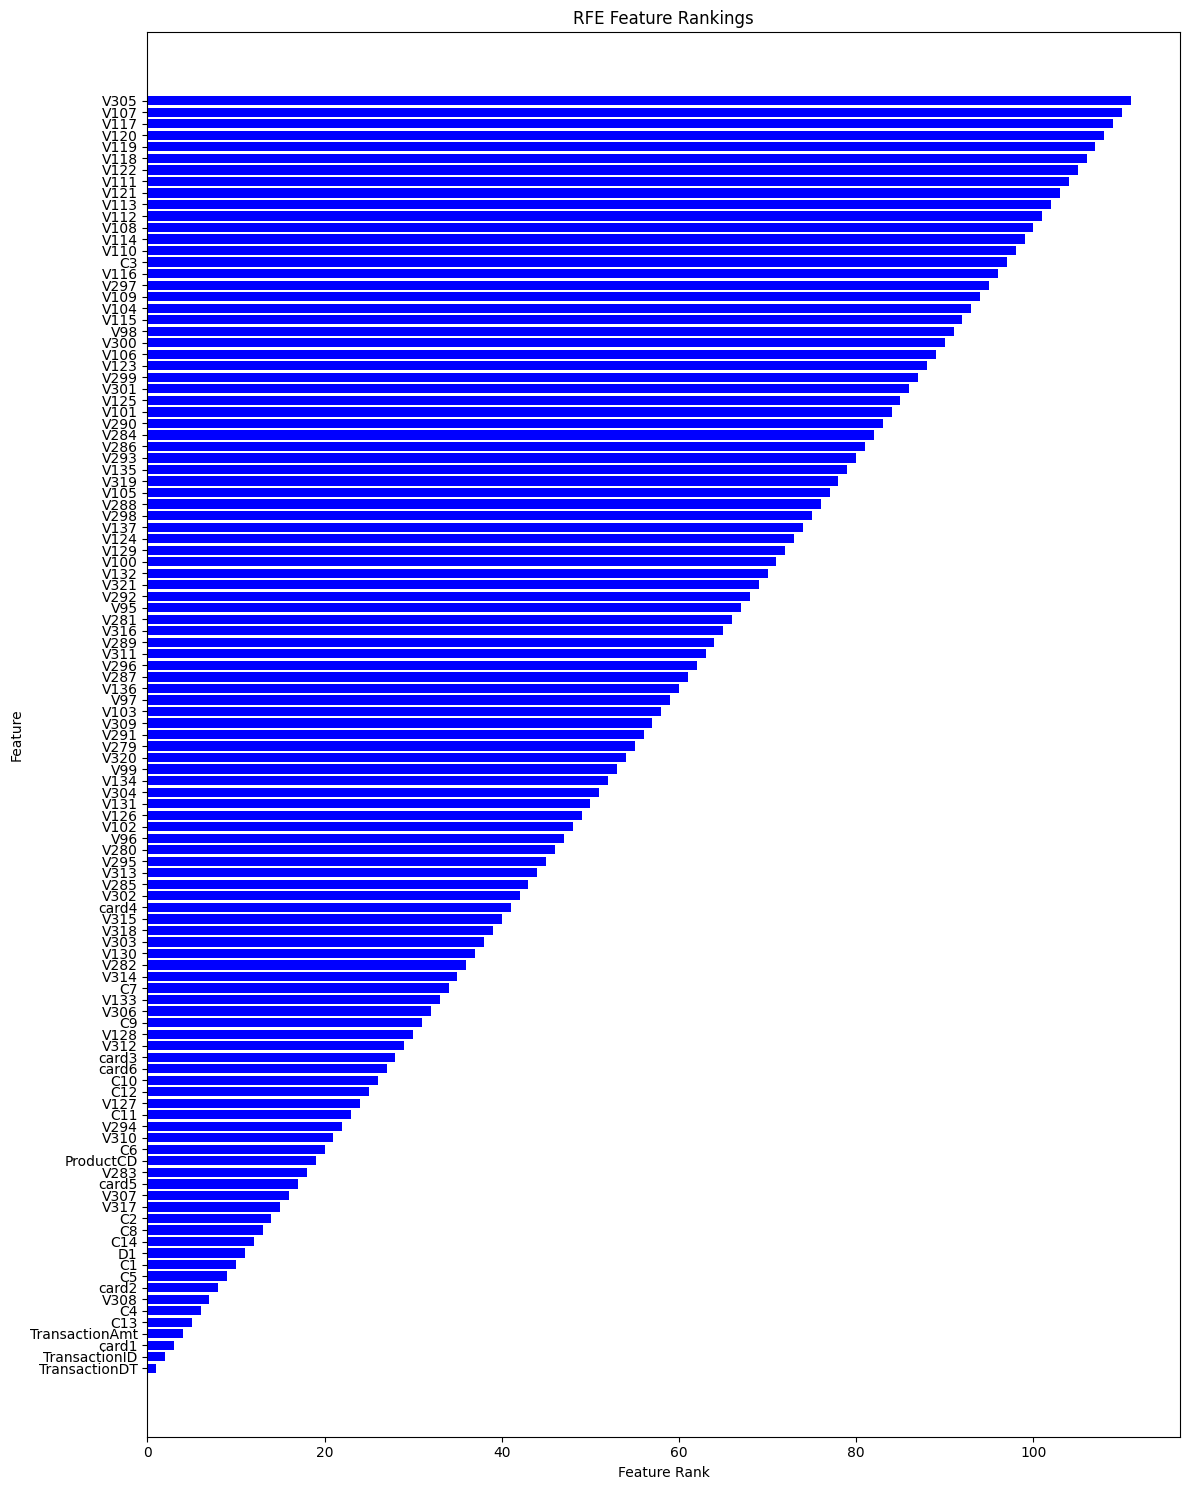

In [38]:
# Create a bar plot for RFE feature rankings
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), feature_rankings[sorted_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Rank')
plt.ylabel('Feature')
plt.title('RFE Feature Rankings')
plt.tight_layout()

plt.savefig('graphs/rfe_feature_rankings.png')
plt.show()

## Use compactness theory to determine the most important weights

### Find the optimal number of neurons for a single-layer perceptron 

In [ ]:
best_model = None
best_model_accuracy = None
best_model_history = None

experiments_number = 5

for neurons in range(1, 11):
    print(f"\nNumber of neurons: {neurons}")
    accuracy_list = []
    for i in range(experiments_number):
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(neurons, input_dim=X_train_scaled.shape[1], activation='sigmoid')
        ])
        model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])

        # Train the model on a sample containing samples of both classes
        perceptron_history = model.fit(X_train_scaled, y_train, verbose=0, epochs=10, batch_size=64, validation_data=(X_valid_scaled, y_valid))

        # evaluate the keras model
        _, accuracy = model.evaluate(X_test_scaled, y_test)

        accuracy_list.append(accuracy)
        print(f'{i+1}) Accuracy: {accuracy*100:.3f}')

        if best_model == None:
            best_model = model
            best_model_accuracy = accuracy
            best_model_history = history
            continue

        if accuracy > best_model_accuracy:
            best_model_accuracy = accuracy
            best_model = model
            best_model_history = history
            print(f'best_model_accuracy: {accuracy*100:.3f}')

    print(f'\nAverage accuracy = {np.mean(accuracy_list)*100:.3f}')

### Use the compactness theory algorithm

In [2]:
df = pd.read_csv('data/final_data/balanced_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41326 entries, 0 to 41325
Columns: 112 entries, TransactionID to isFraud
dtypes: float64(105), int64(7)
memory usage: 35.3 MB


In [3]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()


counter = 0

for label in df['isFraud'].unique():
    label_data = df[df['isFraud'] == label].copy()
    label_data.reset_index(inplace=True)
    label_data.drop('index', axis=1, inplace=True)
    
    split_index = int(0.8 * len(label_data))
    if counter != 0:
        train_df = pd.concat([train_df, label_data[:split_index]])
        test_df = pd.concat([test_df, label_data[split_index:]])
    else:
        train_df = label_data[:split_index]
        test_df = label_data[split_index:]
        
    counter += 1
    
print(f'len(train_df) = {len(train_df)}')
print(f'len(test_df) = {len(test_df)}')

len(train_df) = 33060
len(test_df) = 8266


In [17]:
X_train = train_df[train_df.columns[:-1]]
y_train = train_df['isFraud'].values

X_test = test_df[test_df.columns[:-1]]
y_test = test_df['isFraud'].values

In [18]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [19]:
print(f'len(X_train) = {len(X_train)}')
print(f'len(y_train) = {len(y_train)}')

print(f'len(X_test) = {len(X_test)}')
print(f'len(y_test) = {len(y_test)}')

len(X_train) = 33060
len(y_train) = 33060
len(X_test) = 8266
len(y_test) = 8266


#### Implementation of the theory of compactness in an algorithmic form - discarding features programmatically

In [ ]:
# Get feature names
current_accuracy = 0

while current_accuracy < 0.9 and X_train_scaled.shape[1] >= 10:
    print('\n')
    # Define and compile the model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
    ])
    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
    # Train the model on a sample containing samples of both classes
    perceptron_history = model.fit(X_train_scaled, y_train, verbose=0, epochs=10, batch_size=64)
    
    # Estimate the accuracy of the model for the current number of features
    _, current_accuracy = model.evaluate(X_test_scaled, y_test)
    
    # Apply the identity (square) matrix with a zero row
    identity_matrix = np.identity(X_train_scaled.shape[1])
    offset = np.zeros((1, X_train_scaled.shape[1]))
    input_matrix = np.vstack([identity_matrix, offset])

    # Calculate the feedback for each row minus the offset
    feedback = model.predict(input_matrix)
    feedback_minus_offset = feedback - model.predict(offset)  # Subtract the offset term

    # Evaluate the weight of inputs in absolute terms
    weights = np.abs(feedback_minus_offset)
    
    # Find the least important feature
    least_important_feature_index = np.argmin(weights[:-1]) #weights[:-1]
    
    # Extract the least important feature from the training, validation and test data
    X_train_scaled = np.delete(X_train_scaled, least_important_feature_index, axis=1)
    X_test_scaled = np.delete(X_test_scaled, least_important_feature_index, axis=1)
    print(f"len(weights) = {len(weights)}")
    print(f"Removed feature index: {least_important_feature_index}; Number of features: {X_train_scaled.shape[1]}; Current accuracy: {current_accuracy:.5f}")

In [ ]:
# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights[:-1].squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/feature_weights.png')
plt.show()

#### Manually discarding features

##### The first iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.2008 - accuracy: 0.6961
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1824 - accuracy: 0.7289
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1803 - accuracy: 0.7312
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1794 - accuracy: 0.7336
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1787 - accuracy: 0.7339
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1781 - accuracy: 0.7364
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1777 - accuracy: 0.7375
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1772 - accuracy: 0.7387
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1768 - accuracy: 0.7393
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2161 - accuracy: 0.6723

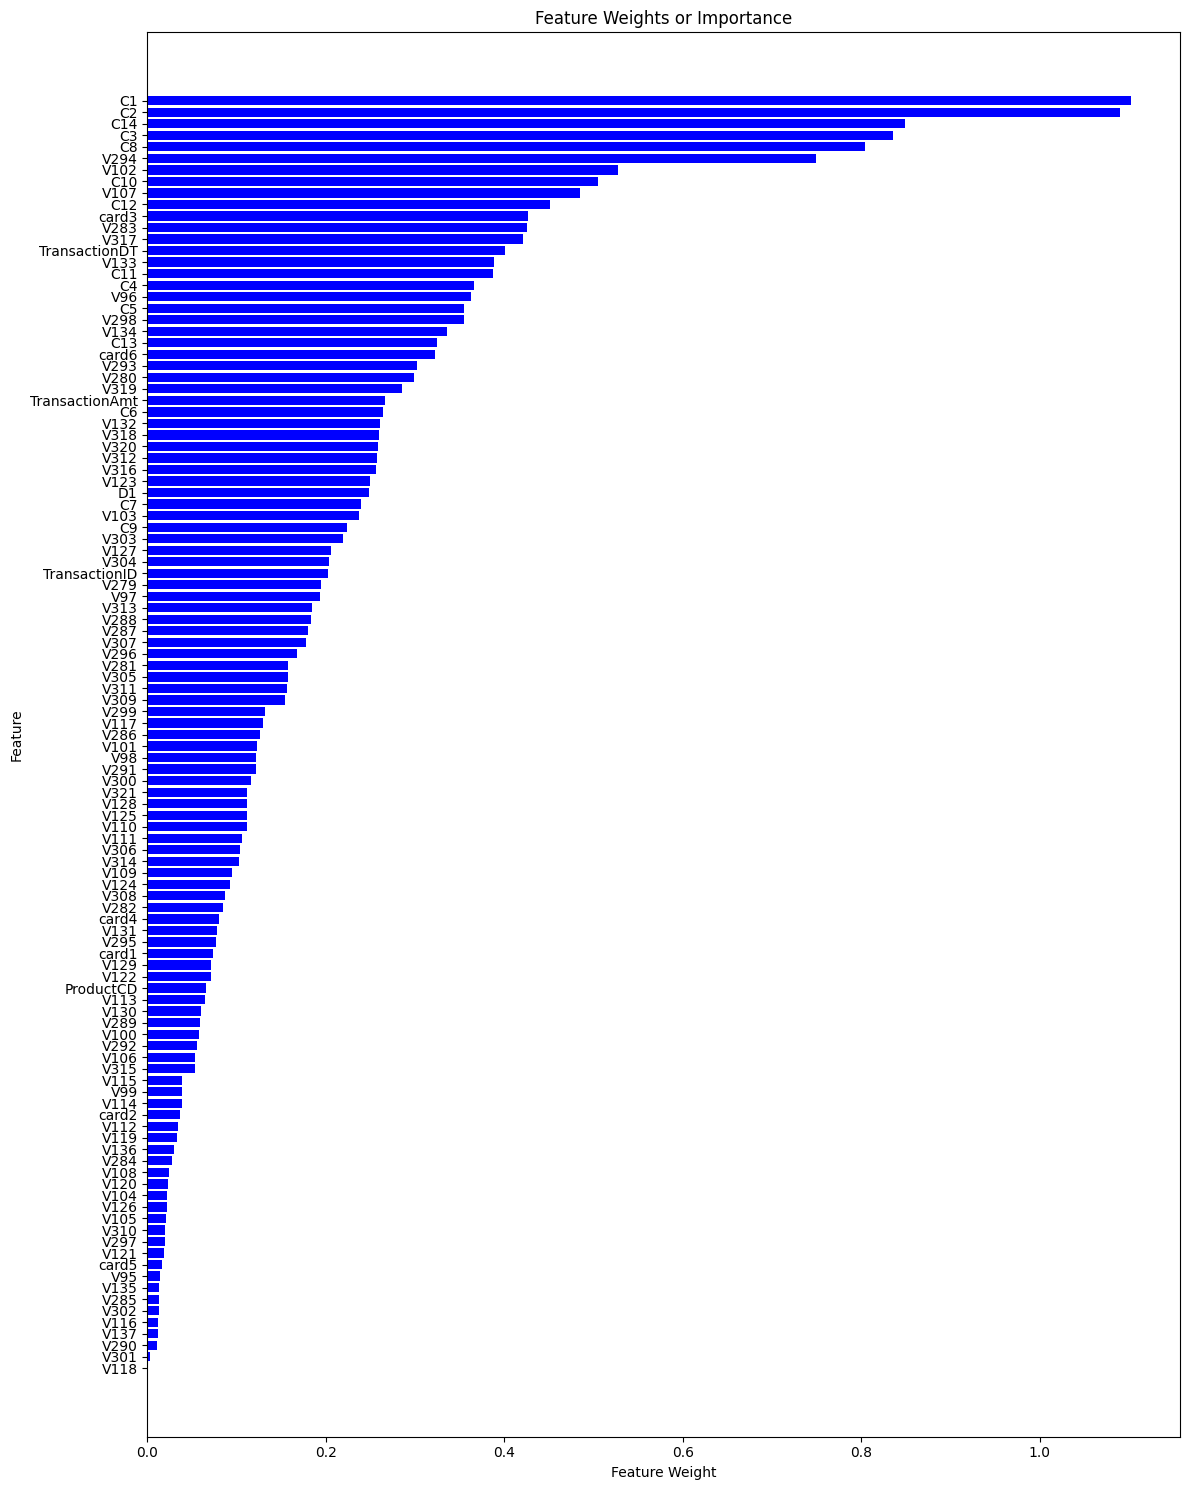

In [20]:
# Get feature names
feature_names = X_train.columns

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/feature_weights.png')
plt.show()

In [21]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V118', 'V301'], axis=1, inplace=True)
X_test.drop(['V118', 'V301'], axis=1, inplace=True)

X_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### The second iteration

In [27]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()
plt.show()

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1971 - accuracy: 0.7091
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1829 - accuracy: 0.7301
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1806 - accuracy: 0.7338
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1793 - accuracy: 0.7351
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1786 - accuracy: 0.7364
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1781 - accuracy: 0.7376
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1776 - accuracy: 0.7389
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1772 - accuracy: 0.7390
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1769 - accuracy: 0.7402
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2176 - accuracy: 0.6680

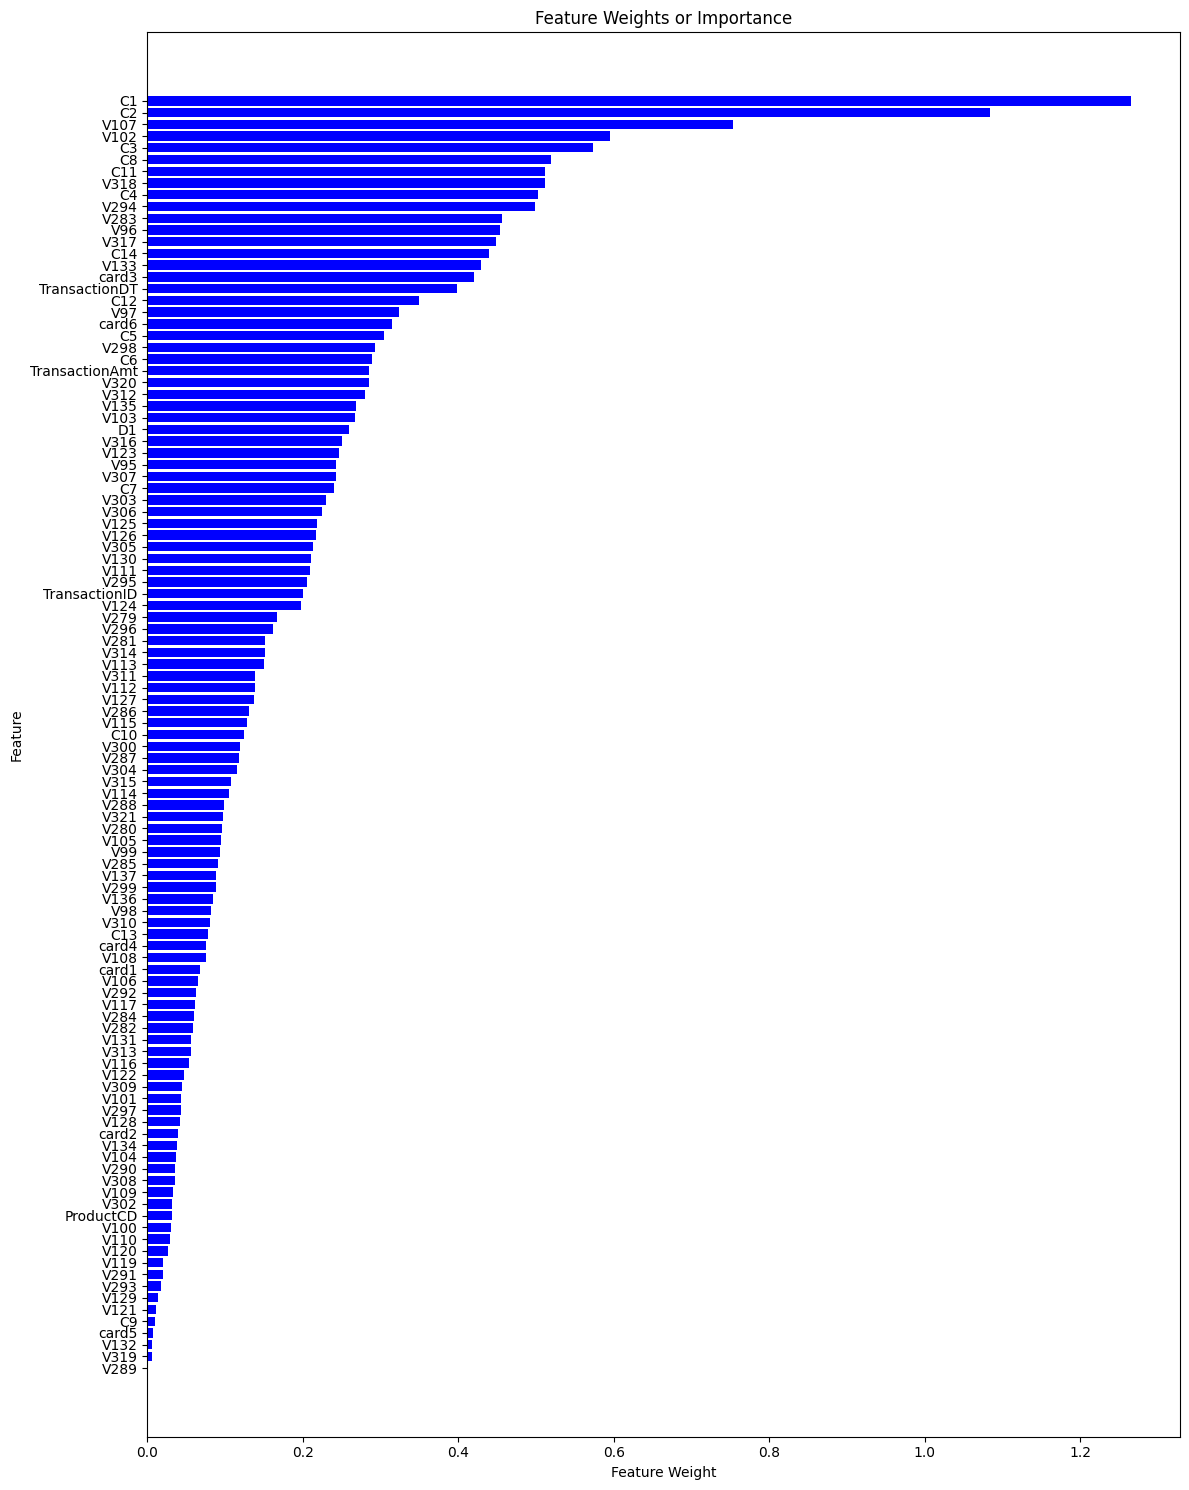

In [30]:
# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/feature_weights.png')
plt.show()

In [31]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop('V289', axis=1, inplace=True)
X_test.drop('V289', axis=1, inplace=True)

X_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_prev.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### The third iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.2051 - accuracy: 0.6842
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1833 - accuracy: 0.7297
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1803 - accuracy: 0.7333
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1792 - accuracy: 0.7362
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1785 - accuracy: 0.7368
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1781 - accuracy: 0.7386
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1776 - accuracy: 0.7389
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1773 - accuracy: 0.7379
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1769 - accuracy: 0.7410
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2178 - accuracy: 0.6680

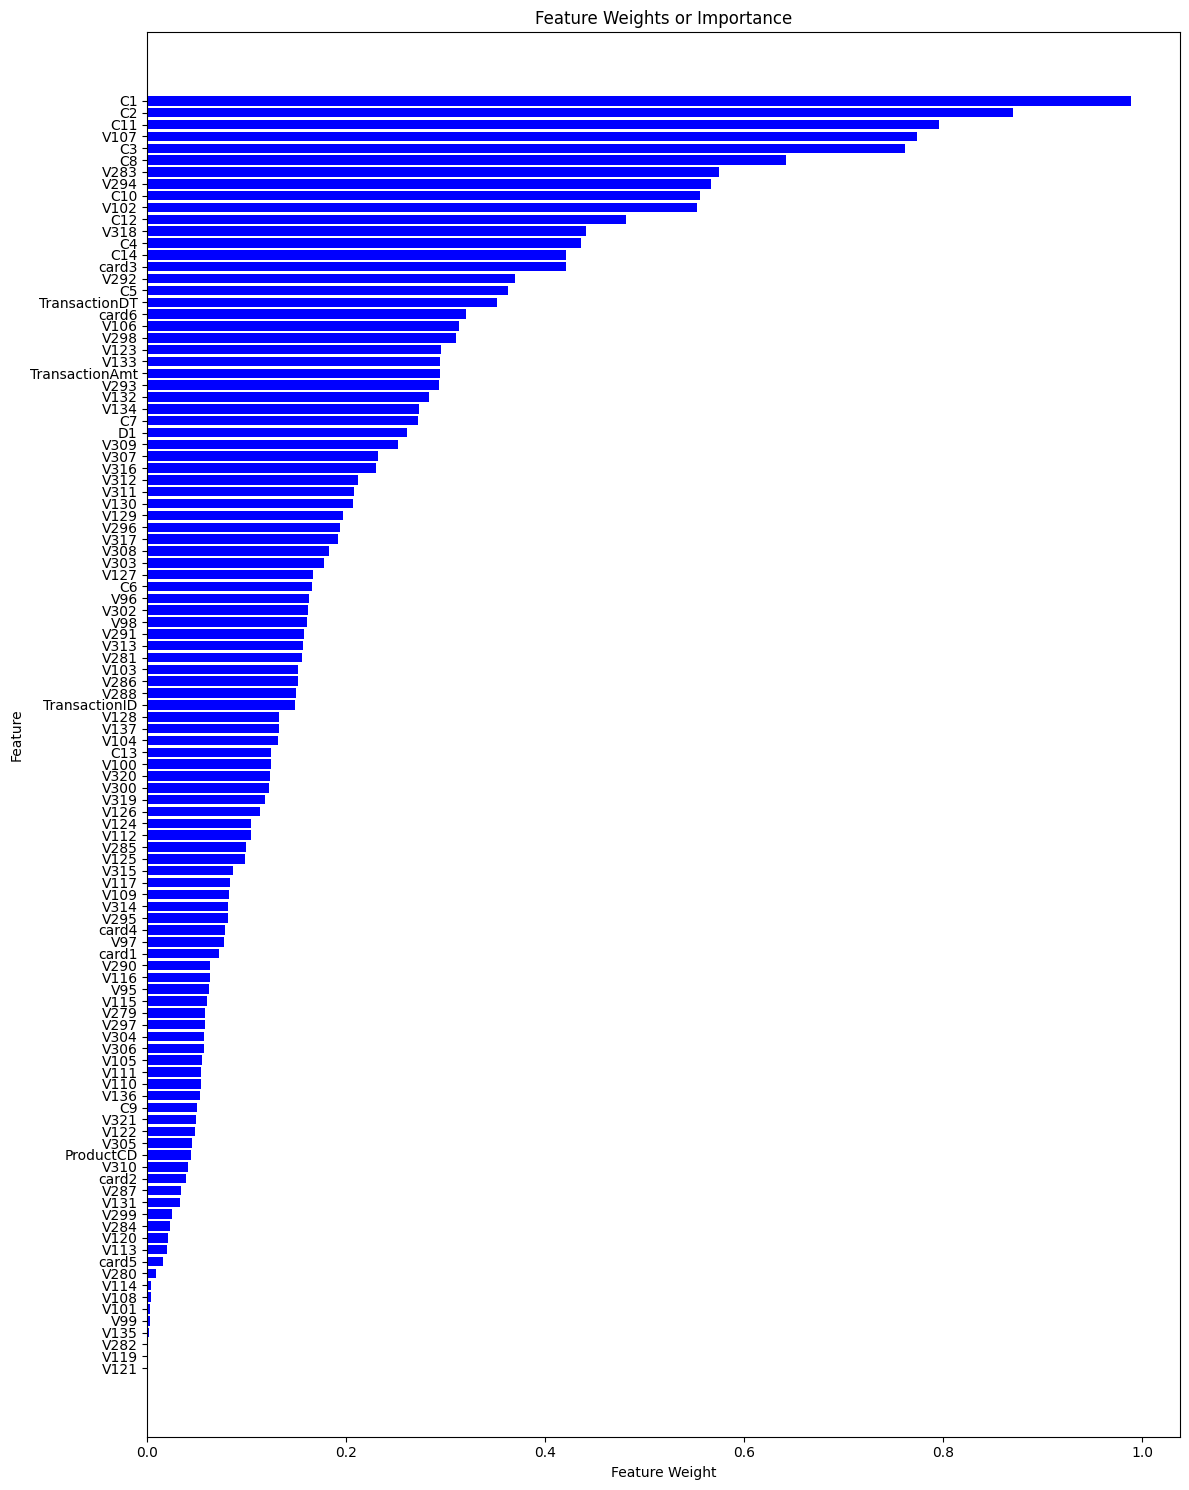

In [33]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/3_1_feature_weights.png')
plt.show()

In [34]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V121', 'V119', 'V282'], axis=1, inplace=True)
X_test.drop(['V121', 'V119', 'V282'], axis=1, inplace=True)

X_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
X_train_prev.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### The fourth iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1983 - accuracy: 0.7011
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1819 - accuracy: 0.7287
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1802 - accuracy: 0.7311
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1793 - accuracy: 0.7340
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1787 - accuracy: 0.7362
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1781 - accuracy: 0.7366
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1777 - accuracy: 0.7368
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1773 - accuracy: 0.7382
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1769 - accuracy: 0.7384
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2184 - accuracy: 0.6653

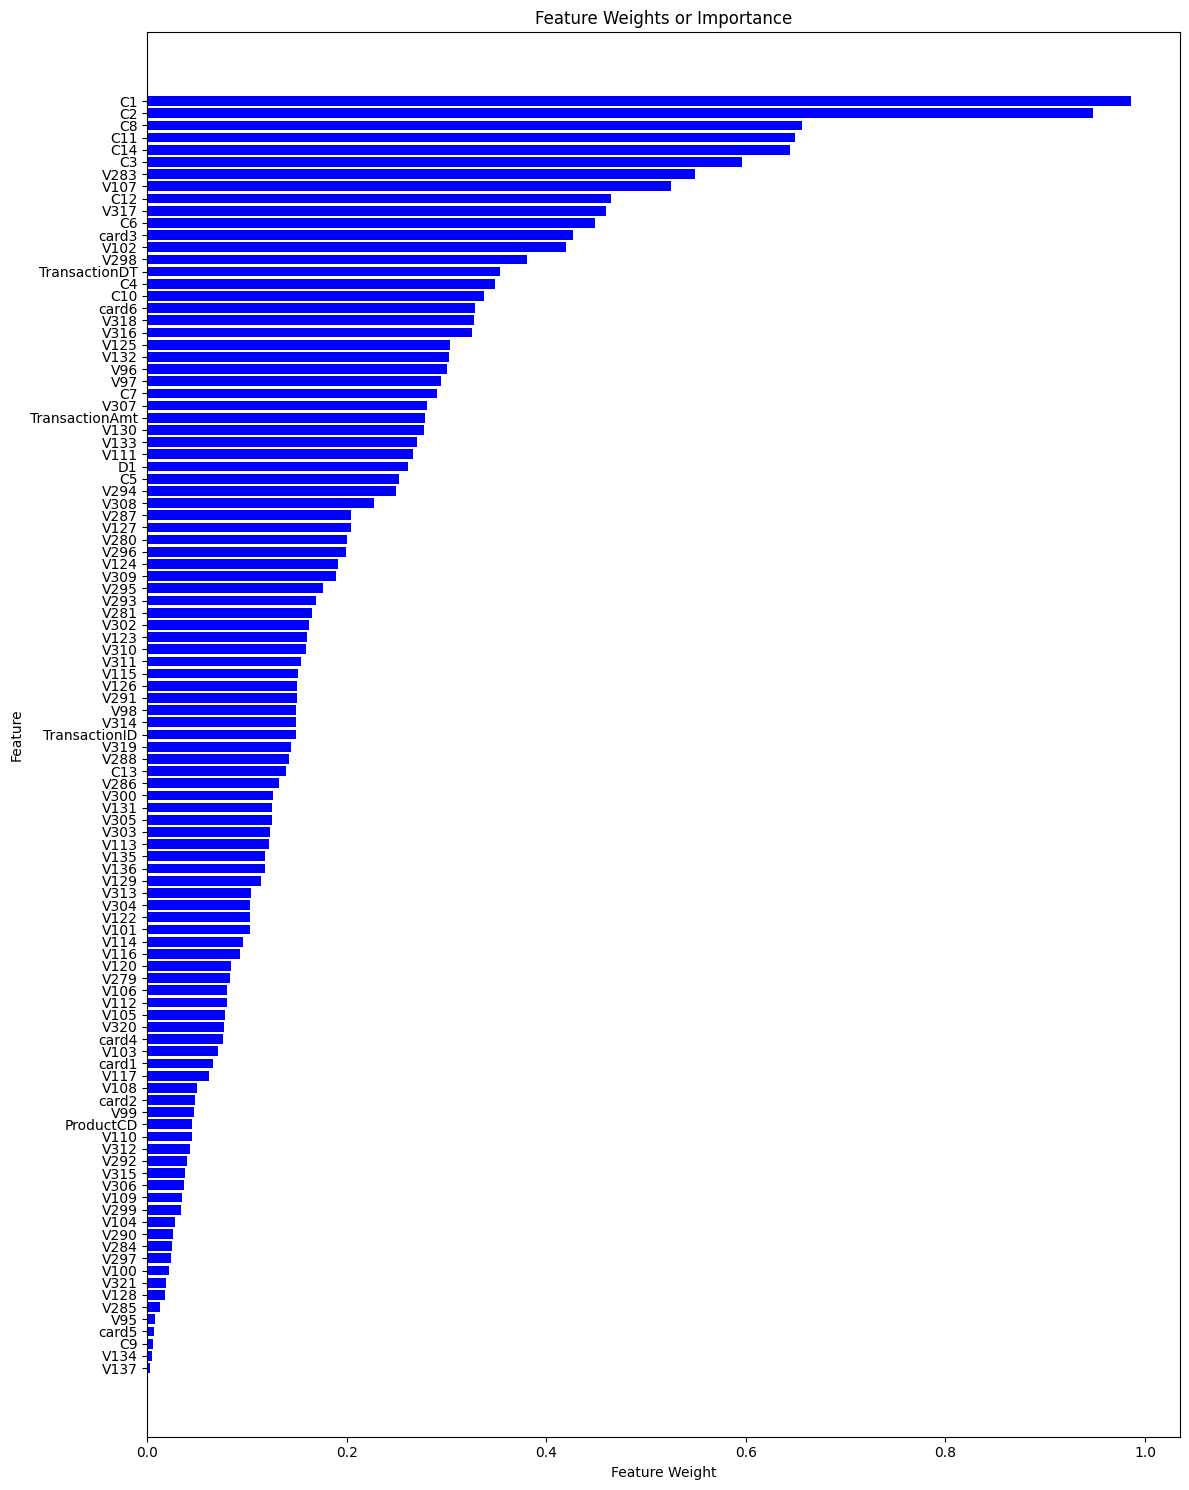

In [36]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/4_1_feature_weights.png')
plt.show()

In [37]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop('V137', axis=1, inplace=True)
X_test.drop('V137', axis=1, inplace=True)

X_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### The fifth iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1950 - accuracy: 0.7103
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1816 - accuracy: 0.7300
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1800 - accuracy: 0.7326
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1791 - accuracy: 0.7359
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1784 - accuracy: 0.7370
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1778 - accuracy: 0.7382
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1774 - accuracy: 0.7387
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1770 - accuracy: 0.7393
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1767 - accuracy: 0.7398
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2215 - accuracy: 0.6597

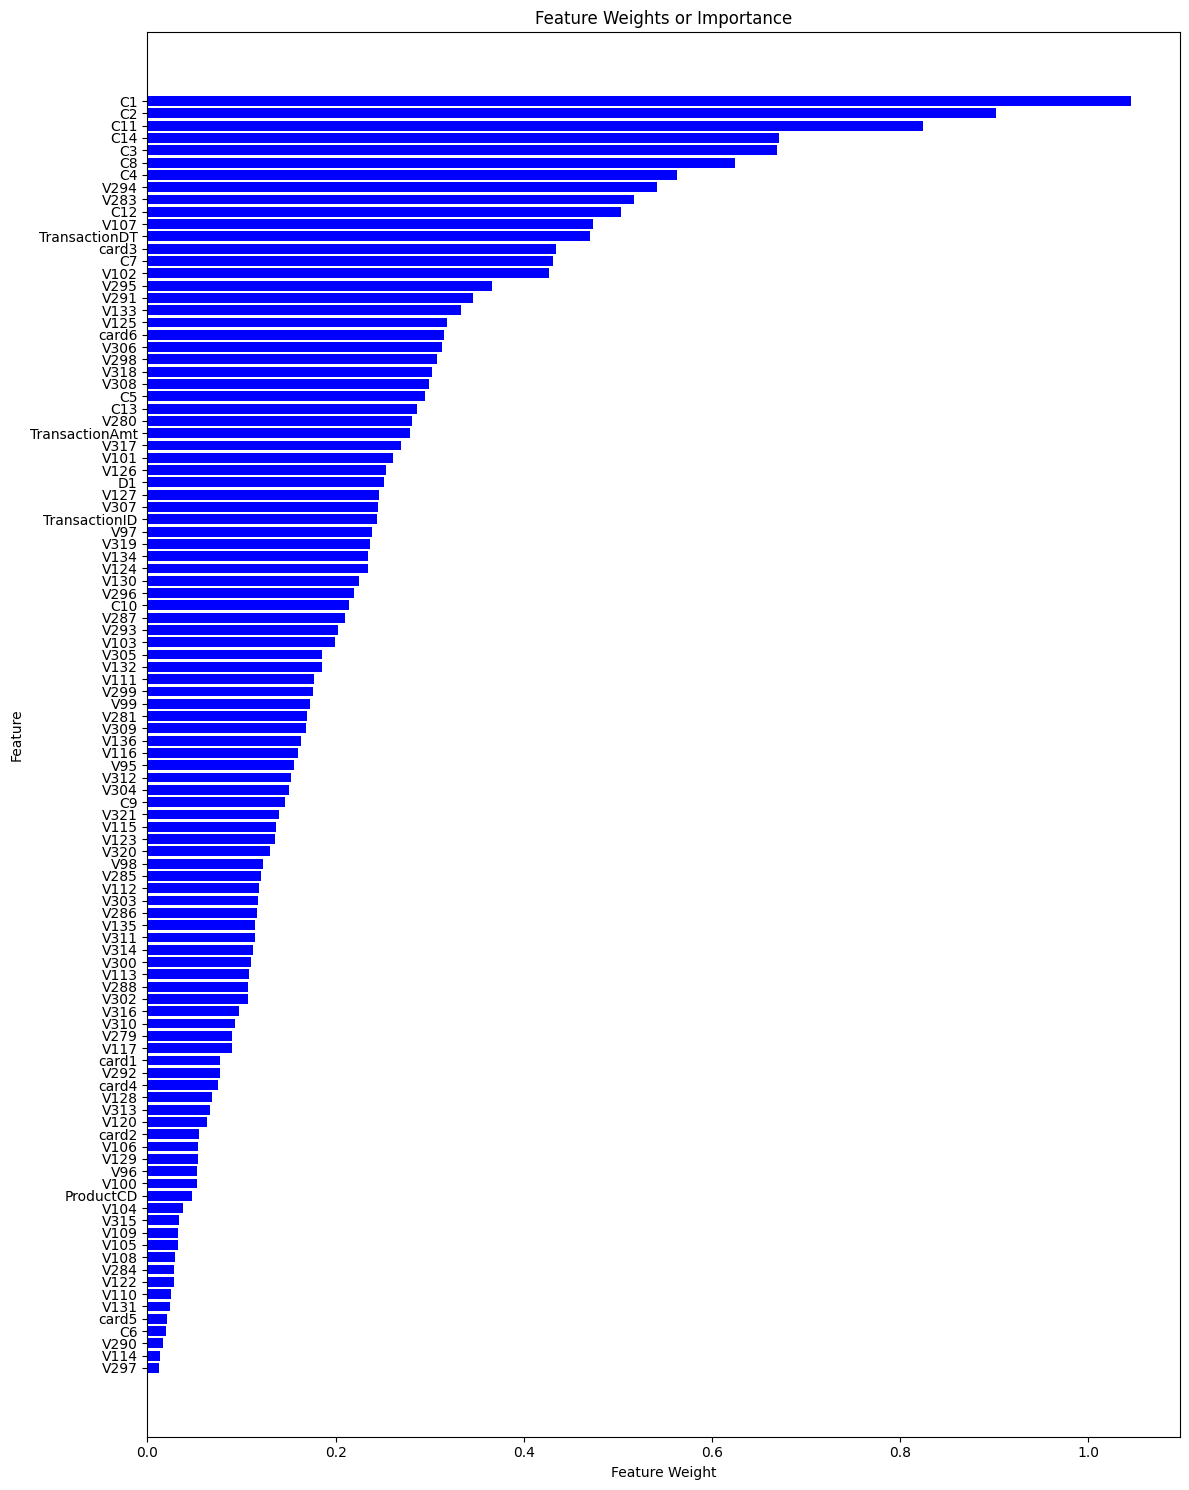

In [39]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/5_1_feature_weights.png')
plt.show()

In [40]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V297', 'V114'], axis=1, inplace=True)
X_test.drop(['V297', 'V114'], axis=1, inplace=True)

X_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train_prev.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### The sixth iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.2019 - accuracy: 0.6961
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1821 - accuracy: 0.7303
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1801 - accuracy: 0.7334
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1791 - accuracy: 0.7348
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1785 - accuracy: 0.7357
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1780 - accuracy: 0.7372
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1776 - accuracy: 0.7380
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1772 - accuracy: 0.7385
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1769 - accuracy: 0.7395
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2153 - accuracy: 0.6715

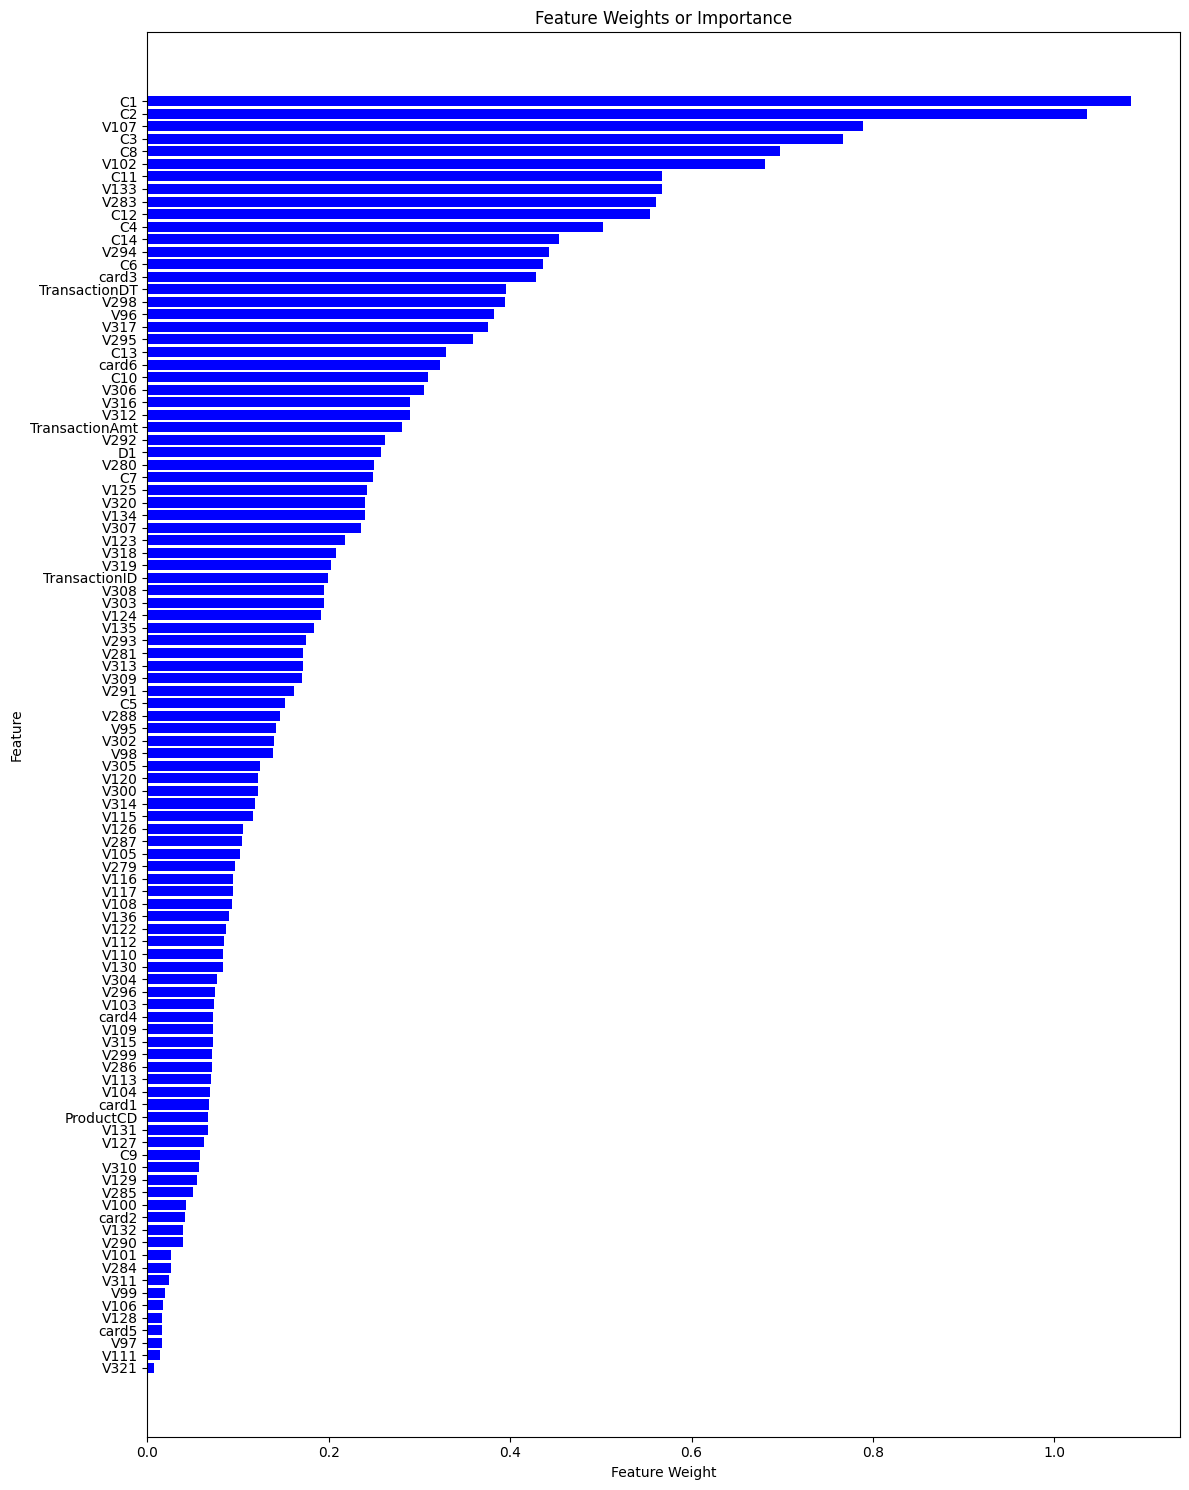

In [42]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/6_1_feature_weights.png')
plt.show()

In [43]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['card5', 'V128', 'V106', 'V311', 'V284'], axis=1, inplace=True)
X_test.drop(['card5', 'V128', 'V106', 'V311', 'V284'], axis=1, inplace=True)

X_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card6,C1,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
X_train_prev.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,137.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,226.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### The seventh iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1999 - accuracy: 0.6954
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1821 - accuracy: 0.7299
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1801 - accuracy: 0.7343
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1791 - accuracy: 0.7361
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1785 - accuracy: 0.7370
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1780 - accuracy: 0.7377
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1776 - accuracy: 0.7394
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1773 - accuracy: 0.7389
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1769 - accuracy: 0.7394
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2154 - accuracy: 0.6740

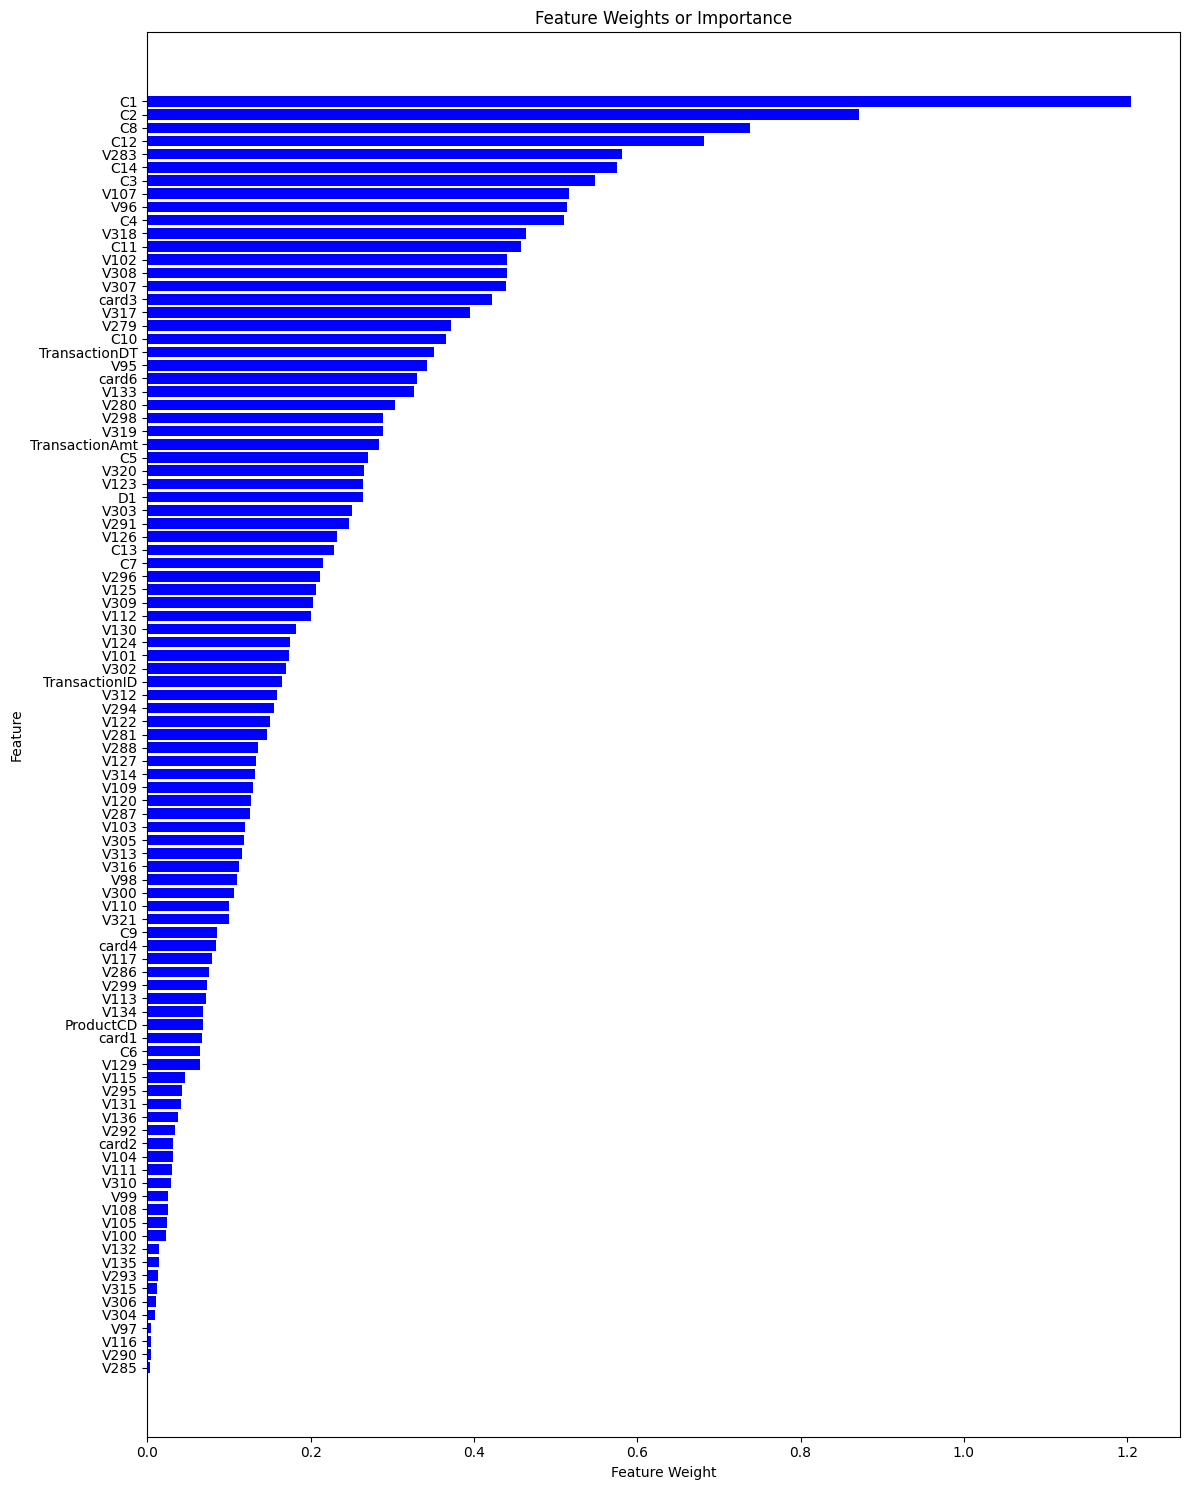

In [45]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/7_1_feature_weights.png')
plt.show()

In [46]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V285', 'V290', 'V97', 'V315', 'V132'], axis=1, inplace=True)
X_test.drop(['V285', 'V290', 'V97', 'V315', 'V132'], axis=1, inplace=True)

X_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card6,C1,...,V310,V312,V313,V314,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### The eighth iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.2095 - accuracy: 0.6733
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1820 - accuracy: 0.7296
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1799 - accuracy: 0.7331
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1791 - accuracy: 0.7350
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1784 - accuracy: 0.7366
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1780 - accuracy: 0.7367
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1776 - accuracy: 0.7377
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1773 - accuracy: 0.7382
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1770 - accuracy: 0.7387
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2145 - accuracy: 0.6719

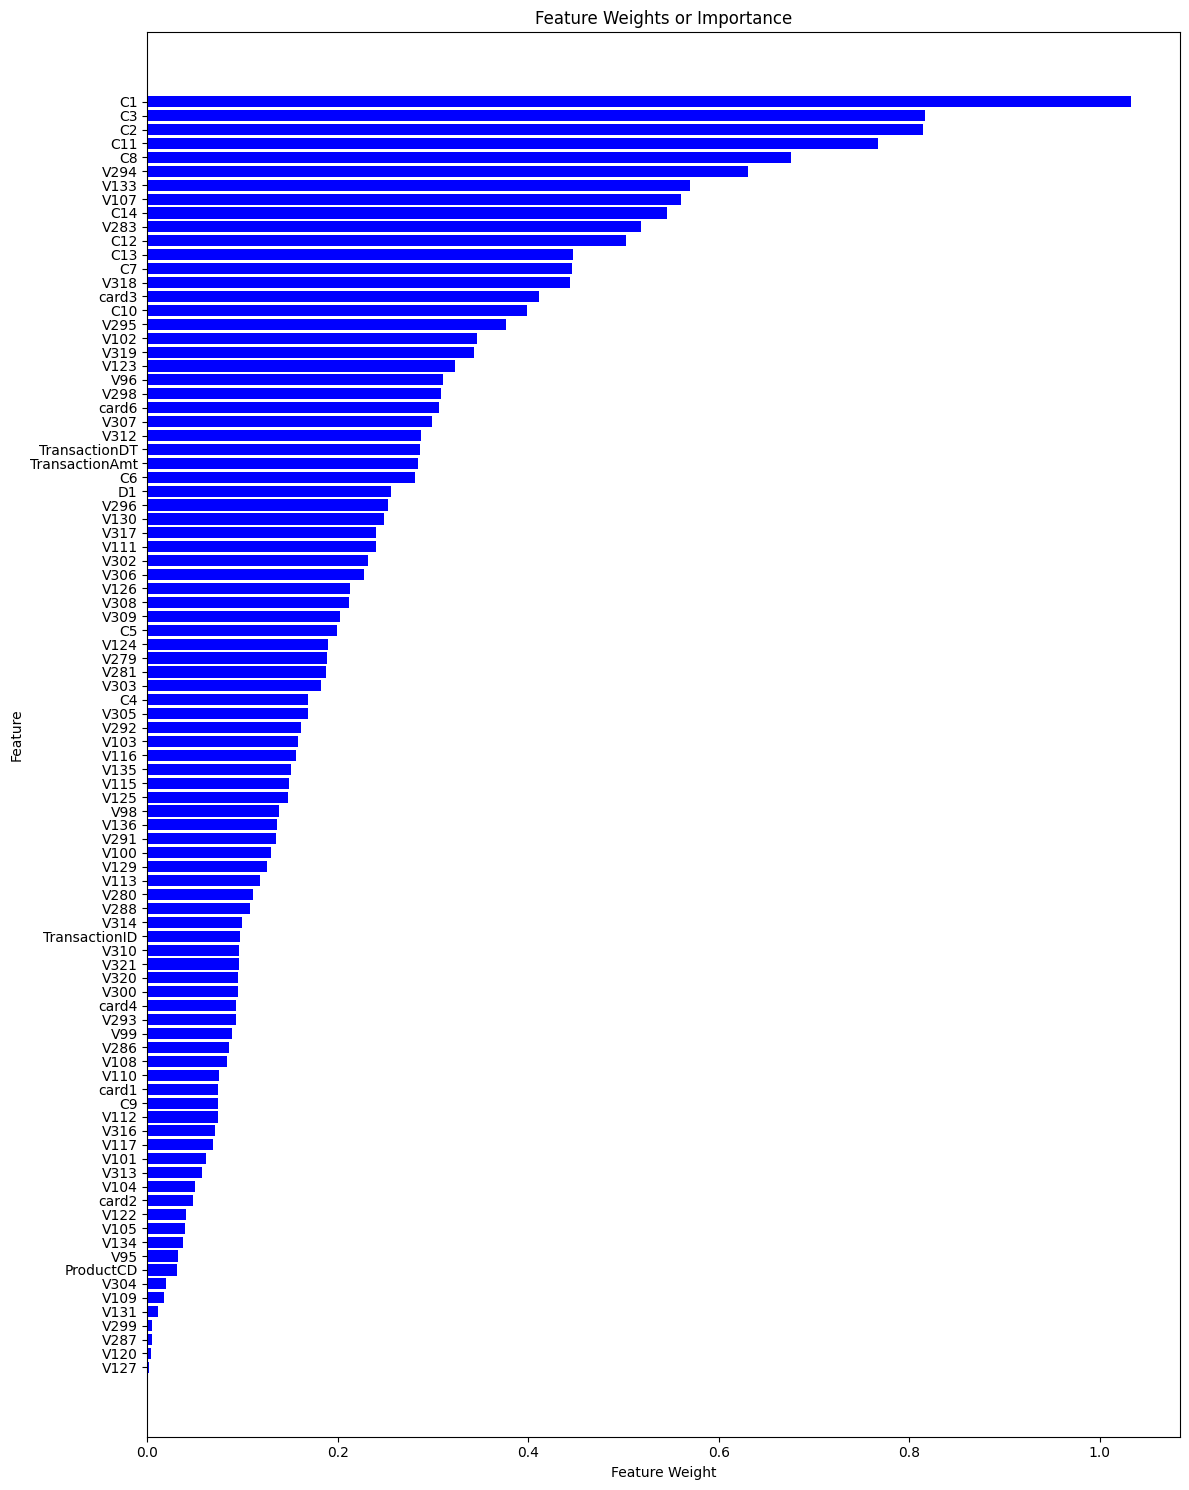

In [48]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/8_1_feature_weights.png')
plt.show()

In [49]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V299', 'V131', 'V304', 'V134'], axis=1, inplace=True)
X_test.drop(['V299', 'V131', 'V304', 'V134'], axis=1, inplace=True)

X_train.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card6,C1,...,V310,V312,V313,V314,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
X_train_prev.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card6,C1,...,V310,V312,V313,V314,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### The ninth iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1987 - accuracy: 0.7056
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1824 - accuracy: 0.7291
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1805 - accuracy: 0.7319
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1796 - accuracy: 0.7346
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1789 - accuracy: 0.7347
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1784 - accuracy: 0.7373
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1779 - accuracy: 0.7372
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1775 - accuracy: 0.7391
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1772 - accuracy: 0.7394
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2201 - accuracy: 0.6586

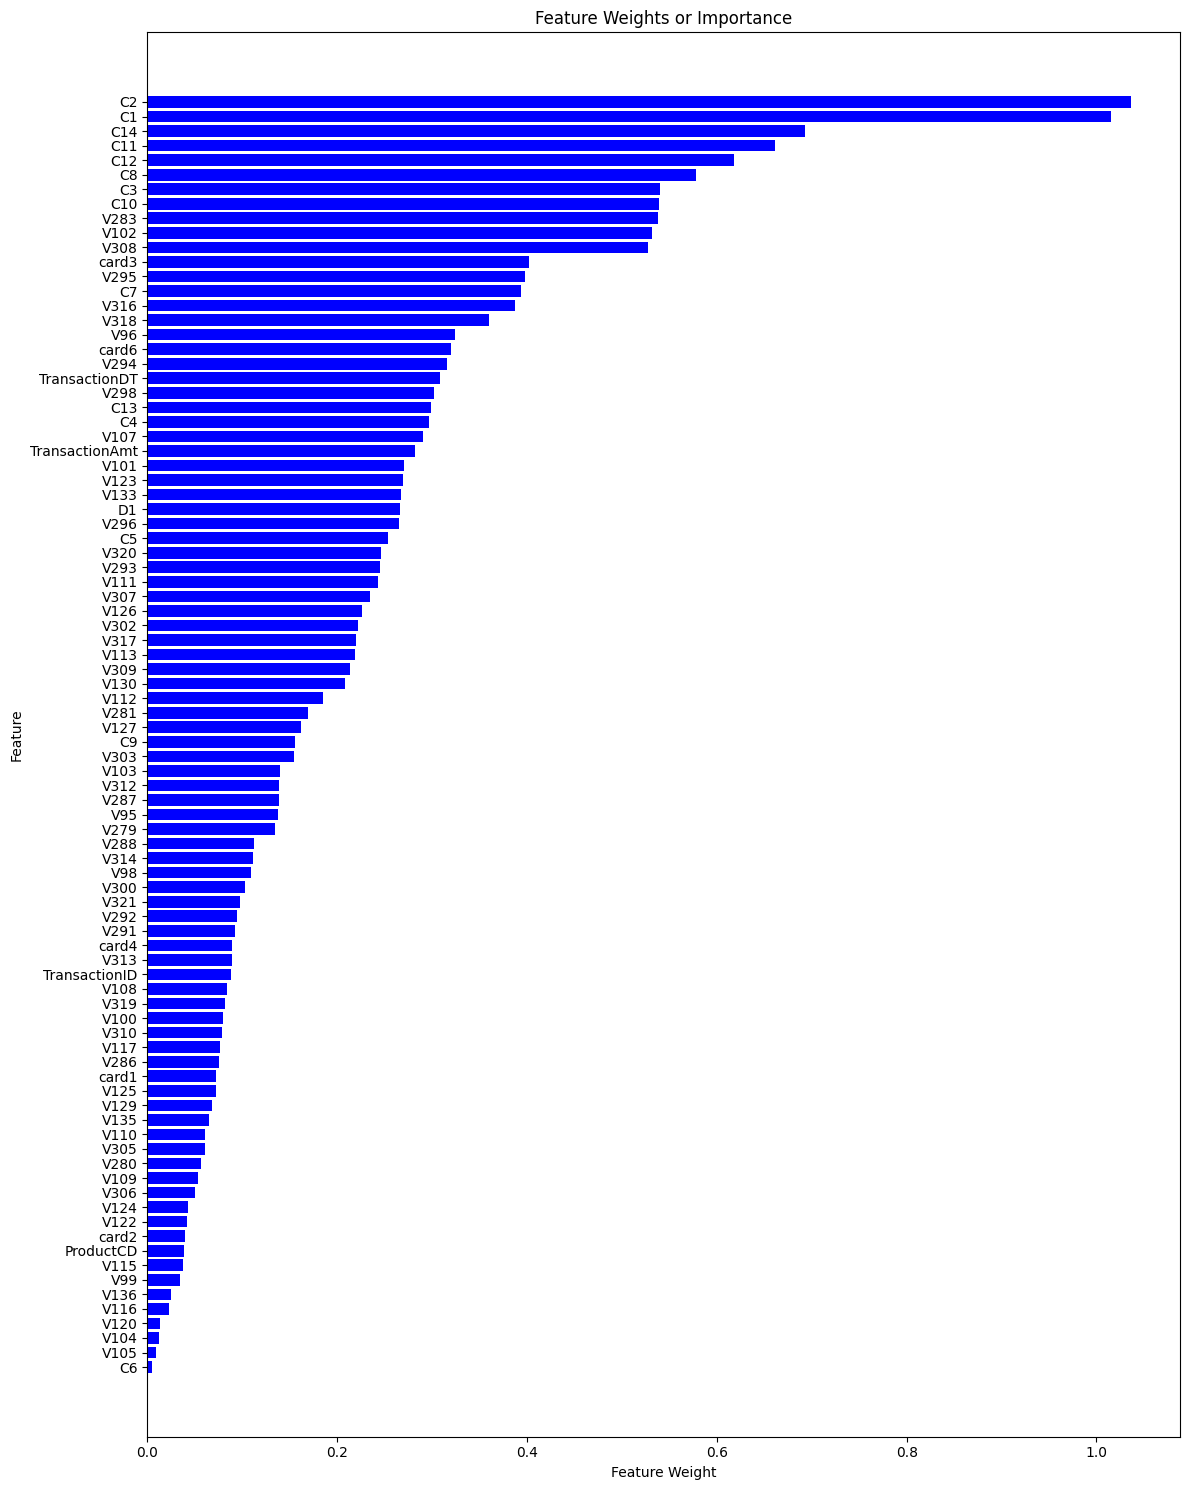

In [51]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/9_1_feature_weights.png')
plt.show()

In [52]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V105', 'V104', 'V120', 'V99', 'ProductCD', 'card2'], axis=1, inplace=True)
X_test.drop(['V105', 'V104', 'V120', 'V99', 'ProductCD', 'card2'], axis=1, inplace=True)

X_train.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card3,card4,card6,C1,C2,C3,...,V310,V312,V313,V314,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,18268,150.0,0,0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,13413,185.0,0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,13413,185.0,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,13413,185.0,0,0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,16578,185.0,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
X_train_prev.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card6,C1,...,V310,V312,V313,V314,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,0,18268,583.0,150.0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,1,13413,103.0,185.0,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,1,13413,103.0,185.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,1,13413,103.0,185.0,0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,1,16578,545.0,185.0,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### The tenth iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1964 - accuracy: 0.7091
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1835 - accuracy: 0.7272
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1809 - accuracy: 0.7316
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1796 - accuracy: 0.7338
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1789 - accuracy: 0.7355
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1784 - accuracy: 0.7366
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1780 - accuracy: 0.7384
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1777 - accuracy: 0.7385
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1773 - accuracy: 0.7400
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2201 - accuracy: 0.6648

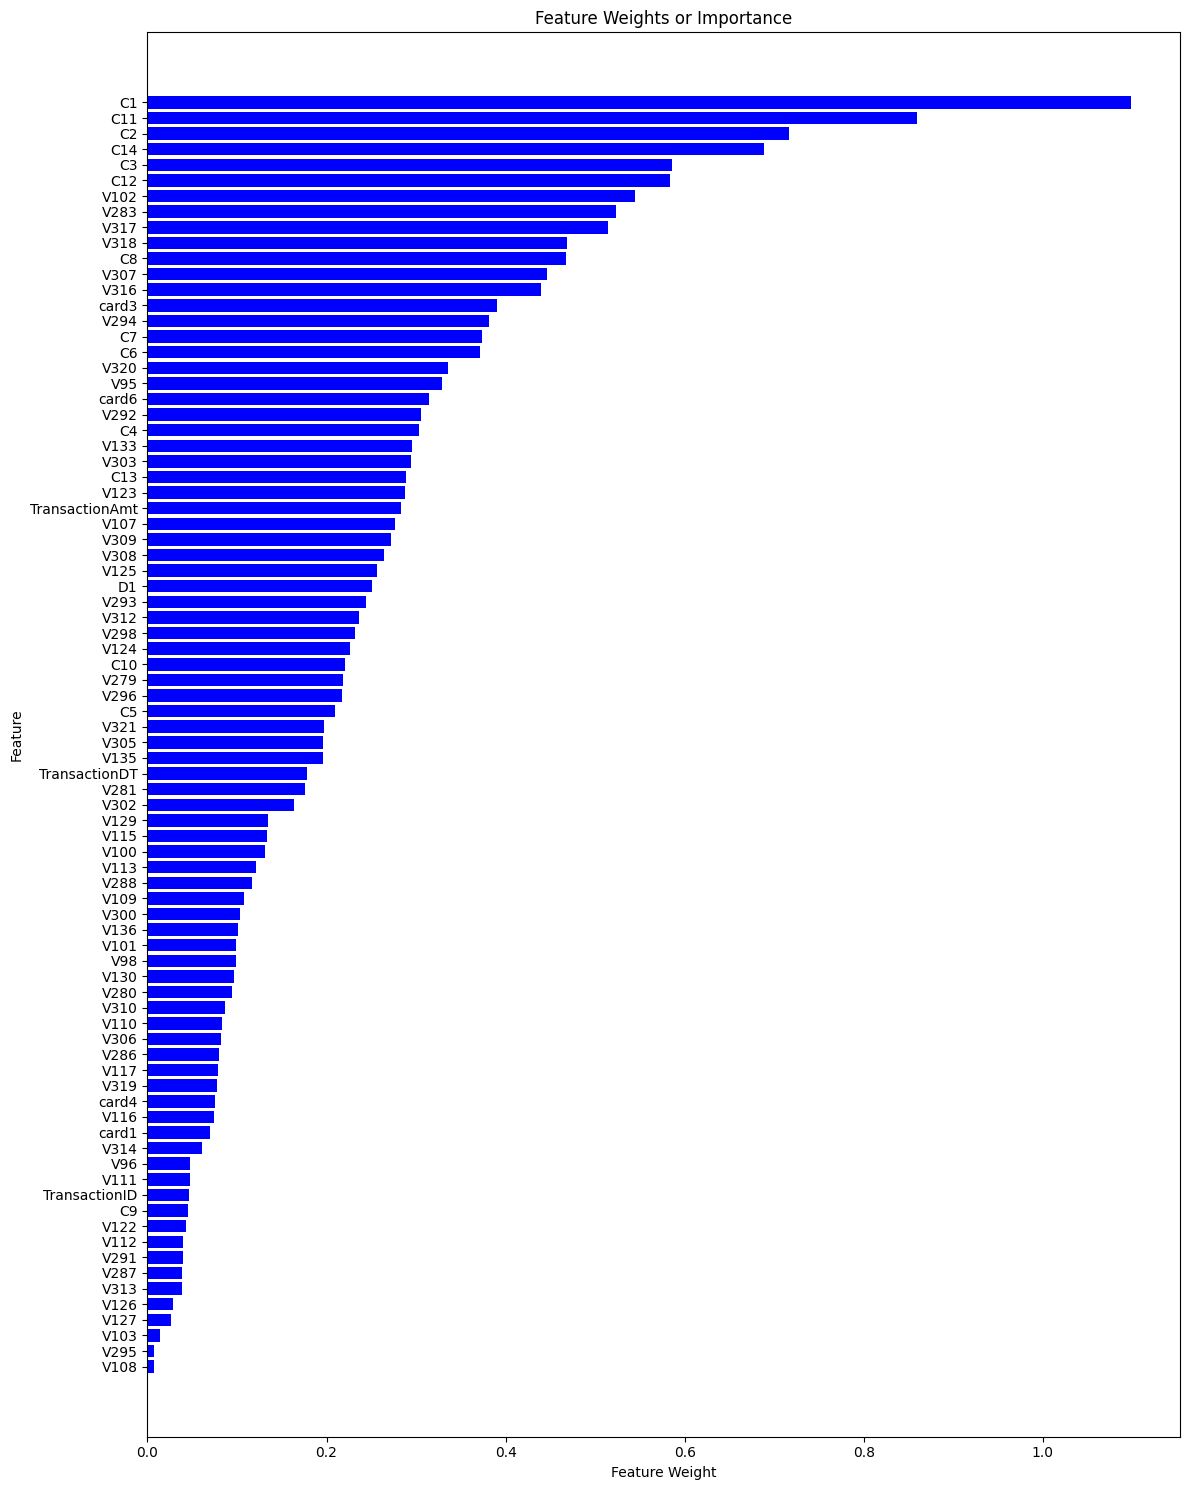

In [54]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/10_1_feature_weights.png')
plt.show()

In [55]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V108', 'V313', 'V287', 'V122'], axis=1, inplace=True)
X_test.drop(['V108', 'V313', 'V287', 'V122'], axis=1, inplace=True)

X_train.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card3,card4,card6,C1,C2,C3,...,V309,V310,V312,V314,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,18268,150.0,0,0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,13413,185.0,0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,13413,185.0,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,13413,185.0,0,0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,16578,185.0,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
X_train_prev.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card3,card4,card6,C1,C2,C3,...,V310,V312,V313,V314,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,18268,150.0,0,0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,13413,185.0,0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,13413,185.0,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,13413,185.0,0,0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,16578,185.0,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### The eleventh iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.2160 - accuracy: 0.6580
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1828 - accuracy: 0.7295
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1804 - accuracy: 0.7325
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1794 - accuracy: 0.7346
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1787 - accuracy: 0.7359
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1782 - accuracy: 0.7374
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1778 - accuracy: 0.7382
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1774 - accuracy: 0.7387
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1771 - accuracy: 0.7390
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2185 - accuracy: 0.6671

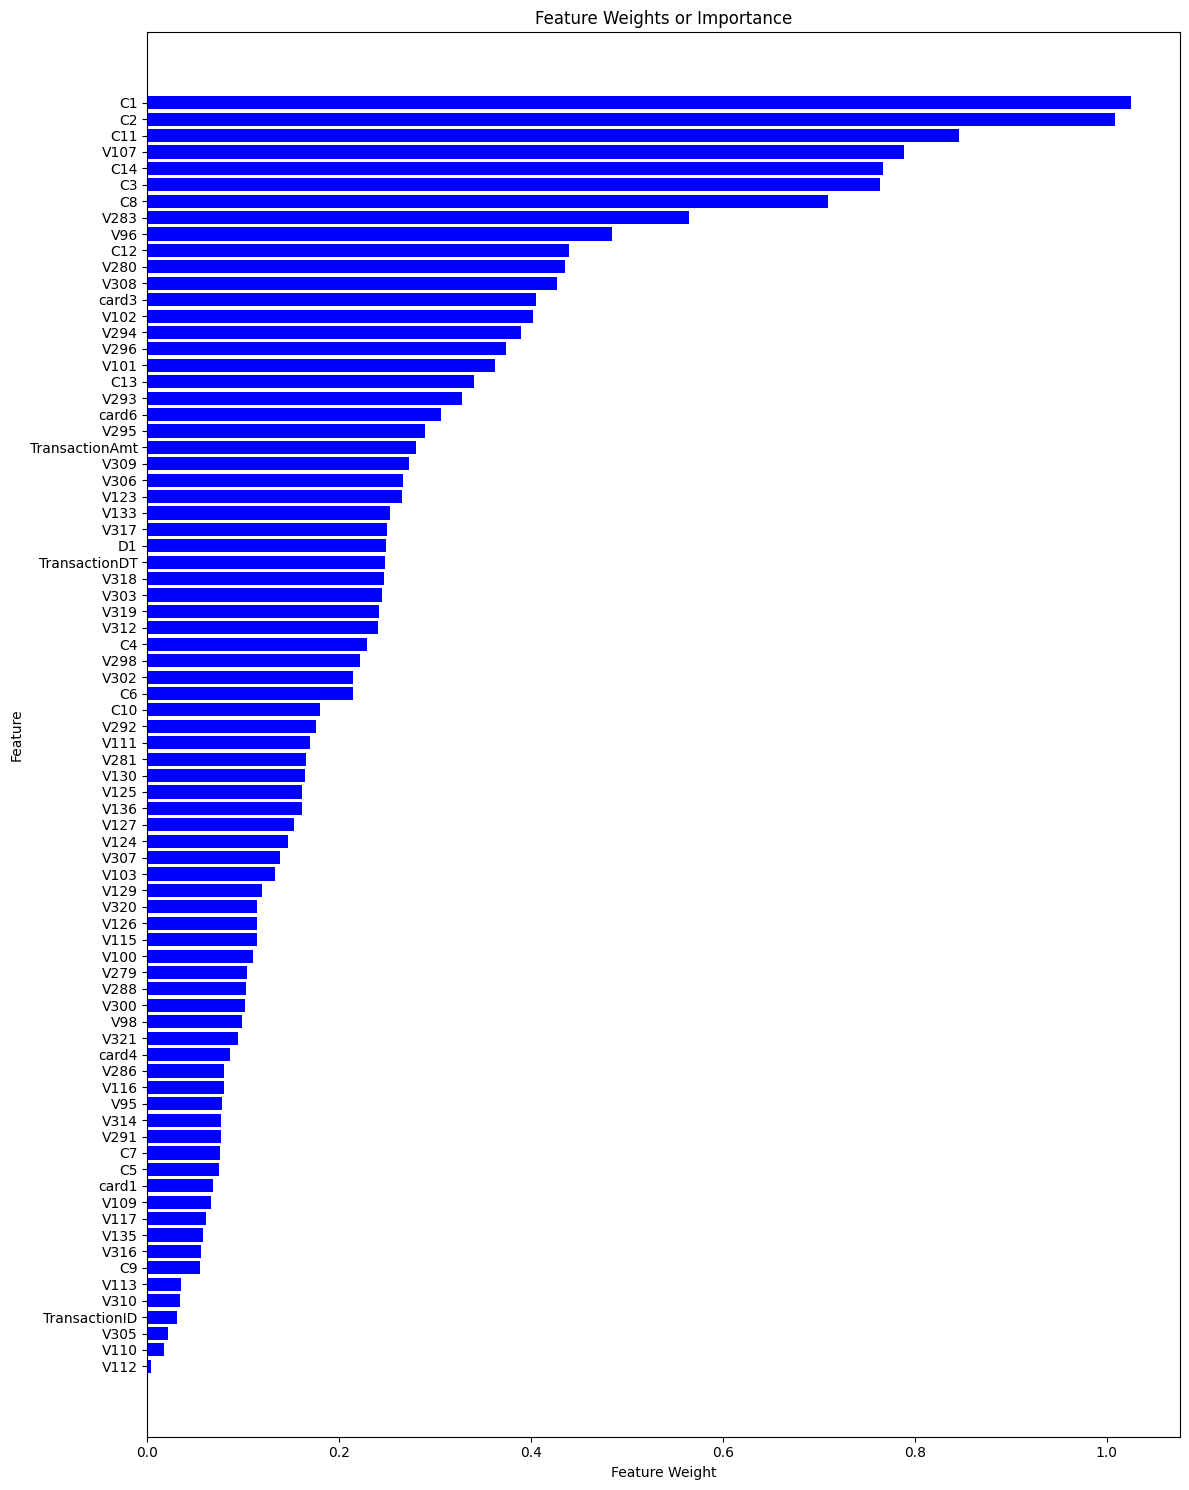

In [57]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/11_1_feature_weights.png')
plt.show()

In [71]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V112', 'V110', 'TransactionID', 'V310', 'V113', 'C9', 'V117'], axis=1, inplace=True) #V113
X_test.drop(['V112', 'V110', 'TransactionID', 'V310', 'V113', 'C9', 'V117'], axis=1, inplace=True)

X_train.head()

,TransactionDT,TransactionAmt,card1,card3,card4,card6,C1,C2,C3,C4,...,V308,V309,V312,V314,V316,V317,V318,V319,V320,V321
0,89760,445.000,18268,150.0,0,0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90193,37.098,13413,185.0,0,0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90246,37.098,13413,185.0,0,0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90295,37.098,13413,185.0,0,0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90986,155.521,16578,185.0,0,0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
X_train_prev.head()

,TransactionID,TransactionDT,TransactionAmt,card1,card3,card4,card6,C1,C2,C3,...,V309,V310,V312,V314,V316,V317,V318,V319,V320,V321
0,2987203,89760,445.000,18268,150.0,0,0,2.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987240,90193,37.098,13413,185.0,0,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987243,90246,37.098,13413,185.0,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987245,90295,37.098,13413,185.0,0,0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2987288,90986,155.521,16578,185.0,0,0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### The twelfth iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.2102 - accuracy: 0.6784
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1831 - accuracy: 0.7261
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1806 - accuracy: 0.7301
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1797 - accuracy: 0.7324
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1790 - accuracy: 0.7338
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1786 - accuracy: 0.7349
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1782 - accuracy: 0.7361
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1779 - accuracy: 0.7367
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1775 - accuracy: 0.7371
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2177 - accuracy: 0.6662

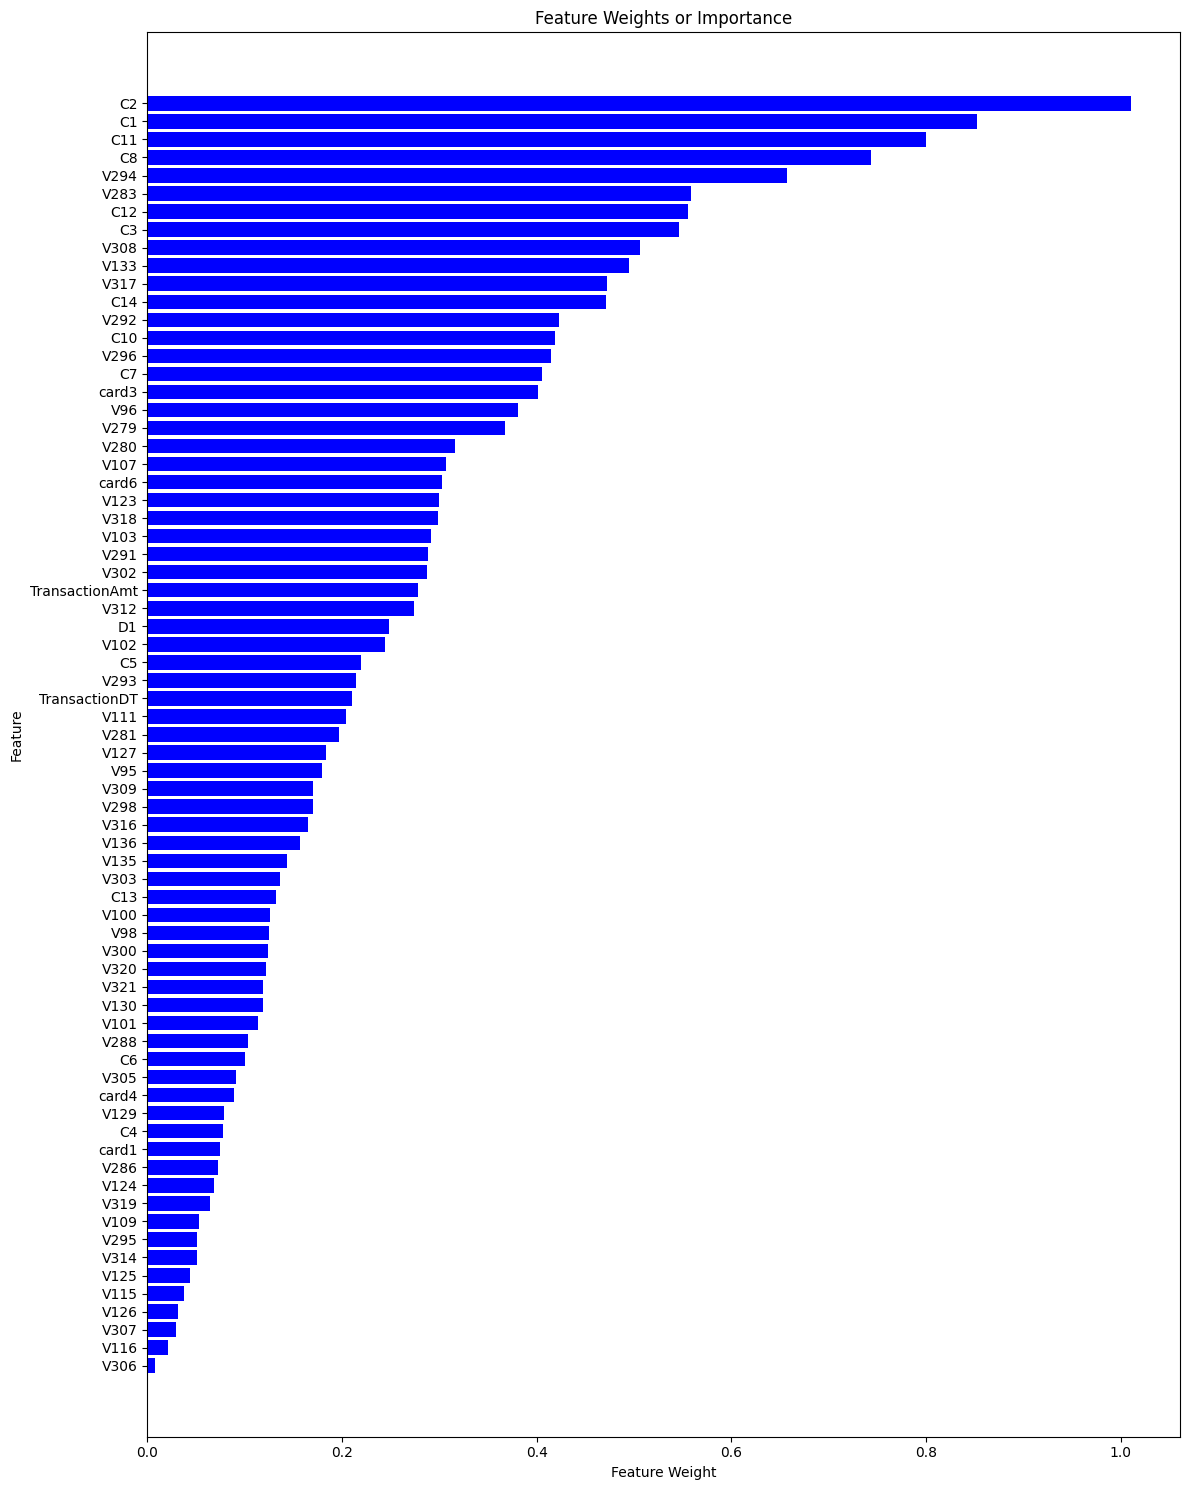

In [73]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/12_1_feature_weights.png')
plt.show()

In [74]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V306', 'V116', 'V115', 'V125', 'V314', 'V109', 'V319'], axis=1, inplace=True)
X_test.drop(['V306', 'V116', 'V115', 'V125', 'V314', 'V109', 'V319'], axis=1, inplace=True)

X_train.head()

,TransactionDT,TransactionAmt,card1,card3,card4,card6,C1,C2,C3,C4,...,V305,V307,V308,V309,V312,V316,V317,V318,V320,V321
0,89760,445.000,18268,150.0,0,0,2.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90193,37.098,13413,185.0,0,0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90246,37.098,13413,185.0,0,0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90295,37.098,13413,185.0,0,0,2.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90986,155.521,16578,185.0,0,0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
X_train_prev.head()

,TransactionDT,TransactionAmt,card1,card3,card4,card6,C1,C2,C3,C4,...,V308,V309,V312,V314,V316,V317,V318,V319,V320,V321
0,89760,445.000,18268,150.0,0,0,2.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90193,37.098,13413,185.0,0,0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90246,37.098,13413,185.0,0,0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90295,37.098,13413,185.0,0,0,2.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90986,155.521,16578,185.0,0,0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### The thirteenth iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.2047 - accuracy: 0.6964
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1835 - accuracy: 0.7277
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1806 - accuracy: 0.7317
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1796 - accuracy: 0.7332
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1789 - accuracy: 0.7361
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1784 - accuracy: 0.7365
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1781 - accuracy: 0.7373
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1777 - accuracy: 0.7387
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1775 - accuracy: 0.7389
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2186 - accuracy: 0.6683

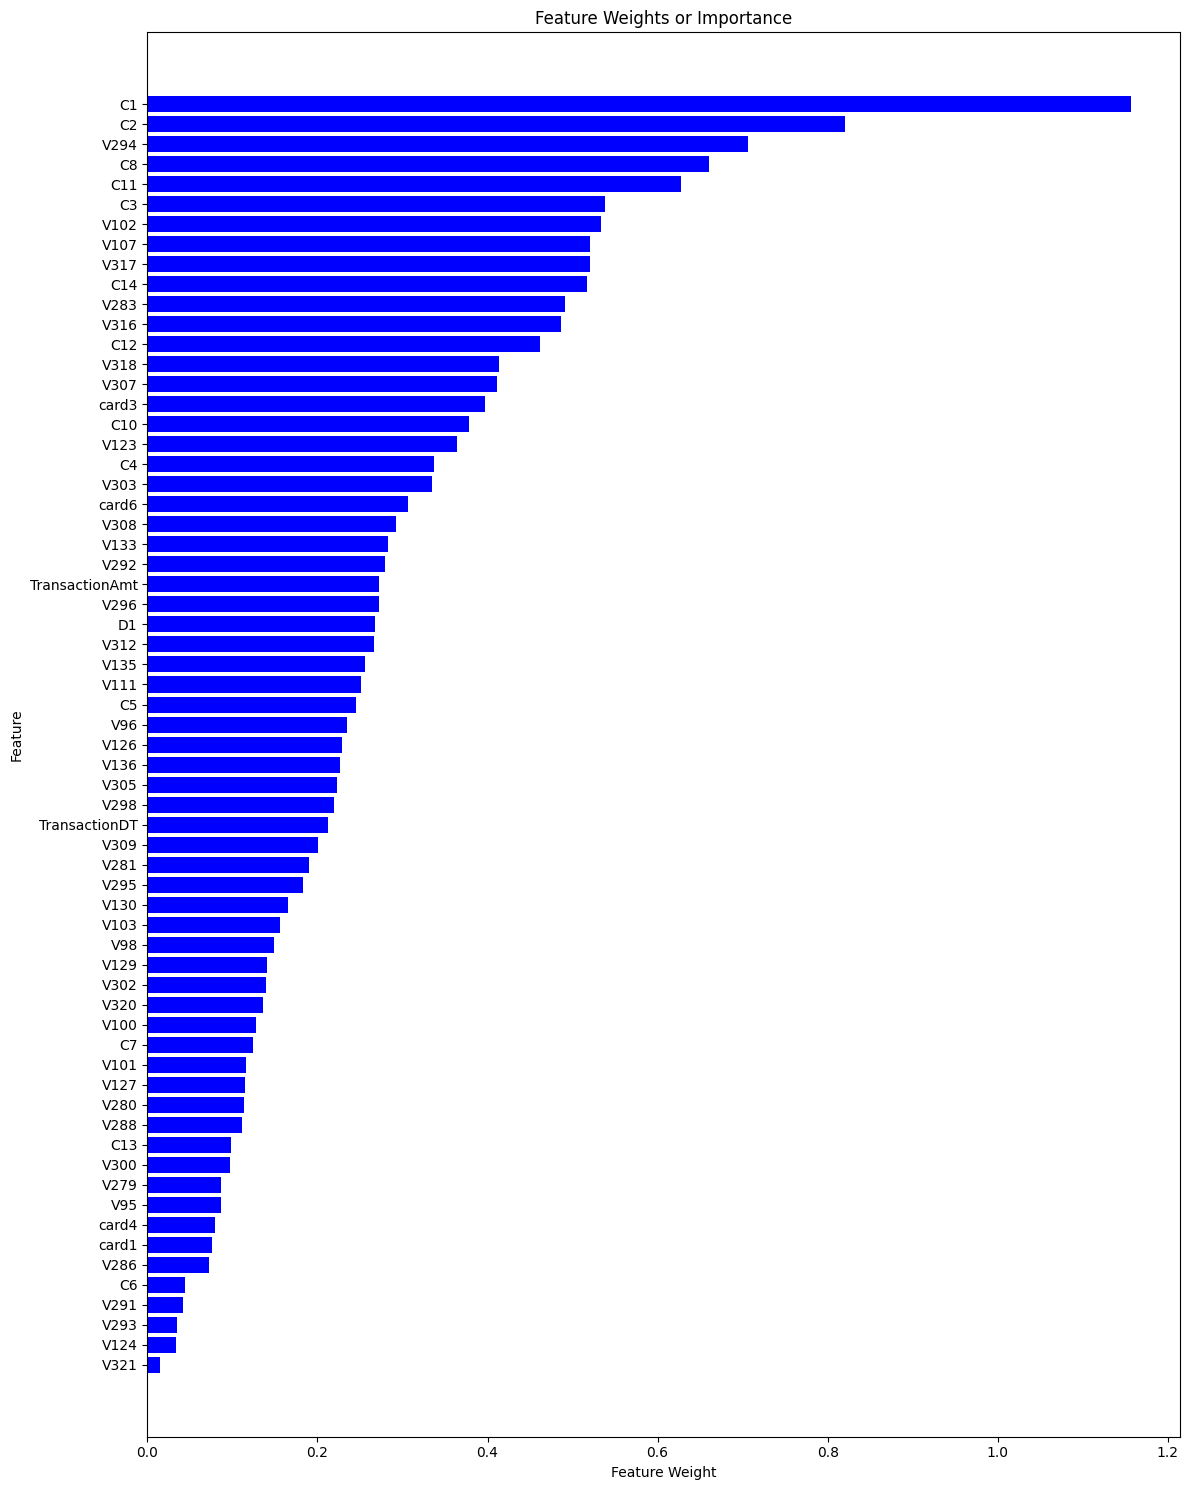

In [76]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/13_1_feature_weights.png')
plt.show()

In [77]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V321', 'V124', 'V291', 'C6', 'V286', 'card1', 'card4', 'V95'], axis=1, inplace=True)
X_test.drop(['V321', 'V124', 'V291', 'C6', 'V286', 'card1', 'card4', 'V95'], axis=1, inplace=True)

X_train.head()

,TransactionDT,TransactionAmt,card3,card6,C1,C2,C3,C4,C5,C7,...,V303,V305,V307,V308,V309,V312,V316,V317,V318,V320
0,89760,445.000,150.0,0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90193,37.098,185.0,0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90246,37.098,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90295,37.098,185.0,0,2.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90986,155.521,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
X_train_prev.head()

,TransactionDT,TransactionAmt,card1,card3,card4,card6,C1,C2,C3,C4,...,V305,V307,V308,V309,V312,V316,V317,V318,V320,V321
0,89760,445.000,18268,150.0,0,0,2.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90193,37.098,13413,185.0,0,0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90246,37.098,13413,185.0,0,0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90295,37.098,13413,185.0,0,0,2.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90986,155.521,16578,185.0,0,0,1.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### The fourteenth iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1948 - accuracy: 0.7130
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1826 - accuracy: 0.7308
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1809 - accuracy: 0.7335
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1799 - accuracy: 0.7350
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1792 - accuracy: 0.7375
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1788 - accuracy: 0.7369
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1785 - accuracy: 0.7384
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1782 - accuracy: 0.7403
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1780 - accuracy: 0.7407
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2190 - accuracy: 0.6674

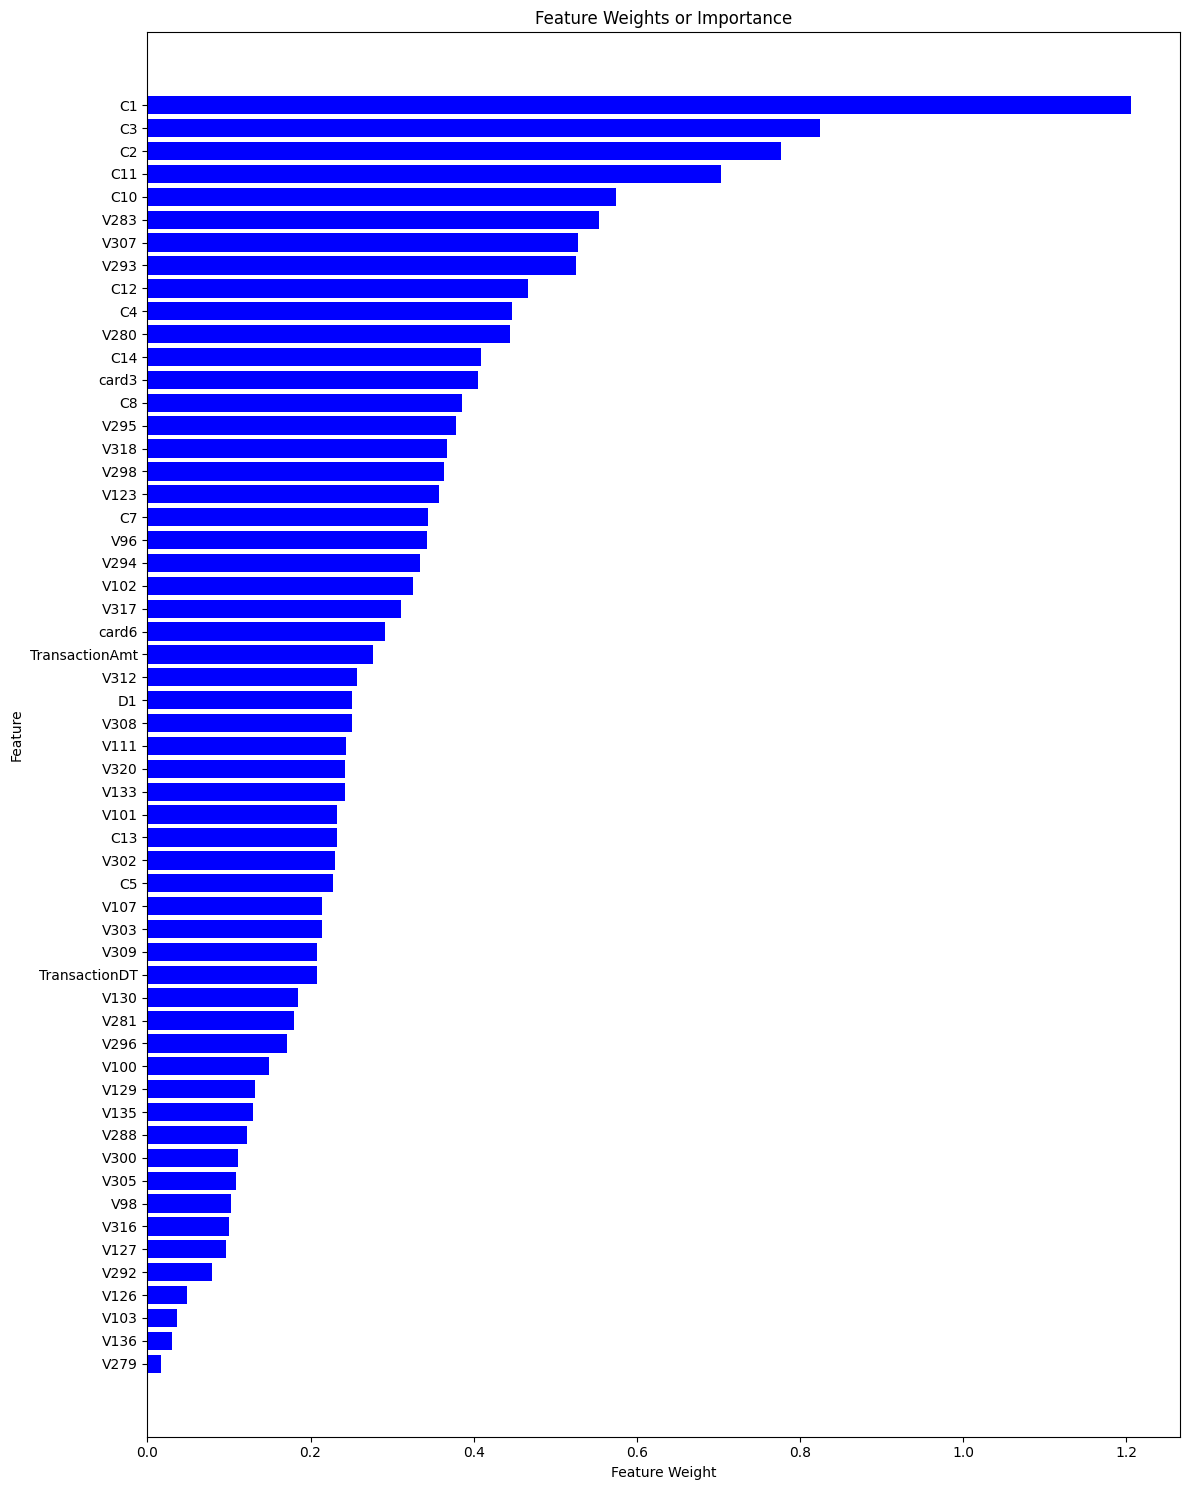

In [79]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/14_1_feature_weights.png')
plt.show()

In [80]:
X_train_prev = X_train.copy()
X_test_prev = X_test.copy()

X_train.drop(['V279', 'V136', 'V103', 'V126', 'V127', 'V98', 'V305', 'V300'], axis=1, inplace=True)
X_test.drop(['V279', 'V136', 'V103', 'V126', 'V127', 'V98', 'V305', 'V300'], axis=1, inplace=True)

X_train.head()

,TransactionDT,TransactionAmt,card3,card6,C1,C2,C3,C4,C5,C7,...,V302,V303,V307,V308,V309,V312,V316,V317,V318,V320
0,89760,445.000,150.0,0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90193,37.098,185.0,0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90246,37.098,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90295,37.098,185.0,0,2.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90986,155.521,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [81]:
X_train_prev.head()

,TransactionDT,TransactionAmt,card3,card6,C1,C2,C3,C4,C5,C7,...,V303,V305,V307,V308,V309,V312,V316,V317,V318,V320
0,89760,445.000,150.0,0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,90193,37.098,185.0,0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,90246,37.098,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,90295,37.098,185.0,0,2.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,90986,155.521,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### The fifteenth iteration

Epoch 1/10
517/517 [==============================] - 1s 1ms/step - loss: 0.2048 - accuracy: 0.6873
Epoch 2/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1834 - accuracy: 0.7305
Epoch 3/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1811 - accuracy: 0.7339
Epoch 4/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1801 - accuracy: 0.7364
Epoch 5/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1795 - accuracy: 0.7372
Epoch 6/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1791 - accuracy: 0.7381
Epoch 7/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1788 - accuracy: 0.7386
Epoch 8/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1785 - accuracy: 0.7391
Epoch 9/10
517/517 [==============================] - 1s 1ms/step - loss: 0.1783 - accuracy: 0.7404
Epoch 10/10
259/259 [==============================] - 0s 1ms/step - loss: 0.2200 - accuracy: 0.6689

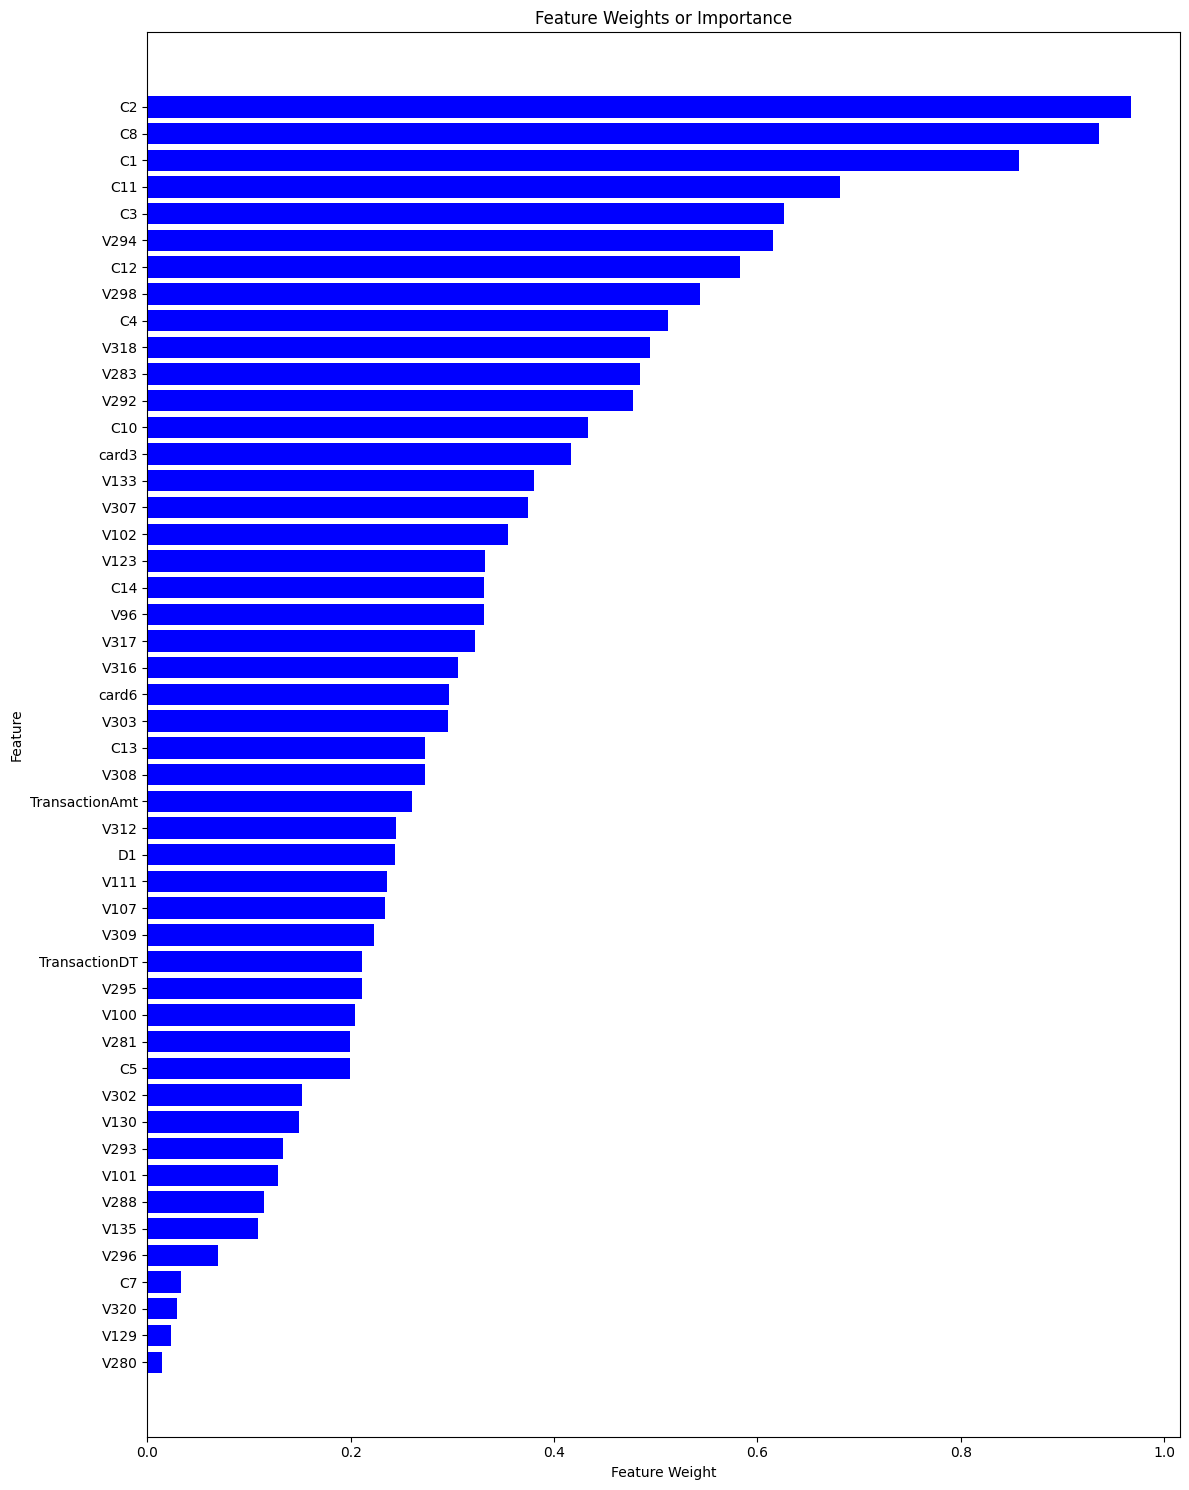

In [82]:
# Get feature names
feature_names = X_train.columns

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_dim=X_train_scaled.shape[1], activation='sigmoid')
])
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.RMSprop(), metrics=['accuracy'])
    
# Train the model on a sample containing samples of both classes
perceptron_history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=64)
    
# Estimate the accuracy of the model for the current number of features
_, current_accuracy = model.evaluate(X_test_scaled, y_test)

weights = np.abs(model.layers[0].get_weights()[0].flatten())

# Sort feature indices based on their weights
sorted_feature_indices = np.argsort(weights.squeeze())

# Sort feature names based on their weights
sorted_feature_names = feature_names[sorted_feature_indices]

# Create a bar plot for feature weights
plt.figure(figsize=(12, 15))
plt.barh(range(len(sorted_feature_names)), weights.squeeze()[sorted_feature_indices], align='center', color='blue')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Feature Weight')
plt.ylabel('Feature')
plt.title('Feature Weights or Importance')
plt.tight_layout()

plt.savefig('graphs/15_1_feature_weights.png')
plt.show()

#### Save results to separate files

In [83]:
train_df = X_train.copy()
train_df['isFraud'] = y_train
train_df.head()

,TransactionDT,TransactionAmt,card3,card6,C1,C2,C3,C4,C5,C7,...,V303,V307,V308,V309,V312,V316,V317,V318,V320,isFraud
0,89760,445.000,150.0,0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,90193,37.098,185.0,0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,90246,37.098,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,90295,37.098,185.0,0,2.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,90986,155.521,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [84]:
test_df = X_test.copy()
test_df['isFraud'] = y_test
test_df.head()

,TransactionDT,TransactionAmt,card3,card6,C1,C2,C3,C4,C5,C7,...,V303,V307,V308,V309,V312,V316,V317,V318,V320,isFraud
0,12145866,12.296,185.0,0,4.0,4.0,0.0,2.0,0.0,2.0,...,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
1,12145992,92.835,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
2,12146123,92.835,185.0,0,2.0,2.0,0.0,1.0,0.0,1.0,...,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
3,12146435,46.417,185.0,0,2.0,3.0,0.0,1.0,0.0,1.0,...,1.0,92.834801,92.834801,0.0,0.0,92.834801,92.834801,92.834801,0.0,1
4,12146724,994.000,150.0,0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1555.000000,0.000000,0.0,0.0,0.000000,884.000000,0.000000,671.0,1


In [85]:
train_df.to_csv('data/final_data/train_48_features.csv', index=False)
test_df.to_csv('data/final_data/test_48_features.csv', index=False)

In [86]:
train_df_test = pd.read_csv('data/final_data/train_48_features.csv')
train_df_test.head()

,TransactionDT,TransactionAmt,card3,card6,C1,C2,C3,C4,C5,C7,...,V303,V307,V308,V309,V312,V316,V317,V318,V320,isFraud
0,89760,445.000,150.0,0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,90193,37.098,185.0,0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,90246,37.098,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,90295,37.098,185.0,0,2.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,90986,155.521,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [87]:
test_df_test = pd.read_csv('data/final_data/test_48_features.csv')
test_df_test.head()

,TransactionDT,TransactionAmt,card3,card6,C1,C2,C3,C4,C5,C7,...,V303,V307,V308,V309,V312,V316,V317,V318,V320,isFraud
0,12145866,12.296,185.0,0,4.0,4.0,0.0,2.0,0.0,2.0,...,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
1,12145992,92.835,185.0,0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
2,12146123,92.835,185.0,0,2.0,2.0,0.0,1.0,0.0,1.0,...,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1
3,12146435,46.417,185.0,0,2.0,3.0,0.0,1.0,0.0,1.0,...,1.0,92.834801,92.834801,0.0,0.0,92.834801,92.834801,92.834801,0.0,1
4,12146724,994.000,150.0,0,3.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1555.000000,0.000000,0.0,0.0,0.000000,884.000000,0.000000,671.0,1
